# 
# License Plates Recognition

Ivan Martín Campoy (NIU), Aina Navarro Ràfols (1670797), Sara Martín Núñez (1669812)

# _Part III: Optical Character Recognition - Convolutional Neural Networks with PyTorch_

https://github.com/josuebatista/PyTorchOCR/blob/main/PyTorch_OCR.ipynb 

In [106]:
#!pip install torch
#!pip install torchvision

In [107]:
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

## 1. Image preprocessing

In [108]:
# Define the data transformations
data_transform = transforms.Compose([
    transforms.Resize((48, 48)),             # Resize the images to 48x48
    transforms.RandomHorizontalFlip(),       # Randomly flip some images horizontally
    transforms.ToTensor(),                   # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))     # Normalize the image tensor
])

# Load the dataset from the './CNN letter Dataset' directory
data = datasets.ImageFolder(
    root='./CNN letter Dataset',
    transform=data_transform
)

# Print out some information about the dataset
print(f"Number of classes: {len(data.classes)}")  # Should print 30
print(f"Total number of images: {len(data)}")

Number of classes: 30
Total number of images: 30450


In [109]:
from PIL import Image

# Load and display the image
image_path = 'CNN letter Dataset/H/aug2282_1.jpg'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
preprocessed_image = preprocess(image)

# Add a batch dimension
input_tensor = preprocessed_image.unsqueeze(0)

# Verify the shape of the input tensor
print(input_tensor.shape)

torch.Size([1, 1, 48, 48])


## 2. Data loading and preparation

In [110]:
def load_split(dataset, batch_size, test_split=0.3, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(test_split * dataset_size))
    train_indices, test_indices = indices[split:], indices[:split]

    testset_size = len(test_indices)
    indices = list(range(testset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(0.5 * testset_size))
    val_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers:
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    # Creating data loaders:
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=test_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=val_sampler)

    return train_loader, test_loader, val_loader

In [111]:
batch_size = 36
train_loader, test_loader, val_loader = load_split(data, batch_size, test_split=0.3)

In [112]:
for batch in train_loader:
    images, labels = batch
    print(images.shape)  # Print the shape of the batch of images
    print(labels.shape)  # Print the shape of the batch of labels
    break  # Print only the first batch

torch.Size([36, 3, 48, 48])
torch.Size([36])


## 3. CNN
Simple Convolutional Neural Network (CNN) architecture for the OCR model. 
Output size = 30, which corresponds to the 30 classes in the dataset.

In [113]:
class OCRNet(nn.Module):
    def __init__(self, num_features):
        super(OCRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(num_features, 30)  # Output has 30 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_features = 32 * 48 * 48  # Adjust this value based on the actual feature size
model = OCRNet(num_features)

In [114]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## 4. Training

In [115]:
def train(model, train_loader, optimizer, criterion, num_epochs=10, print_every=100):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_count = 0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_count += 1

            # Print average loss every 'print_every' mini-batches
            if (i+1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss: {running_loss/running_count:.4f}")
                running_loss = 0.0
                running_count = 0

        # Print loss after each epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"\nEnd of Epoch {epoch+1}/{num_epochs}, Average Epoch Loss: {epoch_loss:.4f}")

In [116]:
train(model, train_loader, optimizer, criterion, num_epochs=20)

Epoch [1/20], Step [100/593], Average Loss: 2.2290
Epoch [1/20], Step [200/593], Average Loss: 1.0298
Epoch [1/20], Step [300/593], Average Loss: 0.7996
Epoch [1/20], Step [400/593], Average Loss: 0.7338
Epoch [1/20], Step [500/593], Average Loss: 0.6906

End of Epoch 1/20, Average Epoch Loss: 0.1008
Epoch [2/20], Step [100/593], Average Loss: 0.5989
Epoch [2/20], Step [200/593], Average Loss: 0.5204
Epoch [2/20], Step [300/593], Average Loss: 0.4998
Epoch [2/20], Step [400/593], Average Loss: 0.5035
Epoch [2/20], Step [500/593], Average Loss: 0.4529

End of Epoch 2/20, Average Epoch Loss: 0.0752
Epoch [3/20], Step [100/593], Average Loss: 0.4531
Epoch [3/20], Step [200/593], Average Loss: 0.4110
Epoch [3/20], Step [300/593], Average Loss: 0.3997
Epoch [3/20], Step [400/593], Average Loss: 0.3732
Epoch [3/20], Step [500/593], Average Loss: 0.3609

End of Epoch 3/20, Average Epoch Loss: 0.0618
Epoch [4/20], Step [100/593], Average Loss: 0.6710
Epoch [4/20], Step [200/593], Average Loss:

In [130]:
# Save the model

folder_path = "OCR_models/CNN/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

torch.save(model.state_dict(), 'OCR_models/CNN/ocr_model1_v2')

In [125]:
# To load a model
model = OCRNet(num_features)
model.load_state_dict(torch.load('OCR_models/CNN/ocr_model1', weights_only=False))
model.eval()  # Model is in evaluation mode

OCRNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=73728, out_features=30, bias=True)
)

## 5. Validation

In [126]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

validate(model, val_loader, criterion)

Validation Loss: 0.0233, Validation Accuracy: 99.52%


## 6. Testing

In [120]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

test(model, test_loader, criterion)

Test Loss: 0.0438, Test Accuracy: 98.99%


## 7. Predict on our plates

In [95]:
classes = list('0123456789BCDFGHJKLMNPRSTVWXYZ')

In [121]:
def predict(model, images_path):

    # To compute accuracy
    correct_digits, correct_plates = 0, 0
    total_digits, total_plates = 0, 0

    # Ensure the model is in evaluation mode
    model.eval()

    # Loop through each folder in the specified directory
    for plate_name in os.listdir(images_path):

        # Cut plate from the name for accuracy
        plate = list(plate_name[:-4])
        predicted_classes = []

        # Entire path
        folder_path = os.path.join(images_path, plate_name)
        
        if os.path.isdir(folder_path):  # Check if it's a directory
            # Get all image files in the folder
            image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
            
            # Check if there are images in the folder
            if len(image_files) == 0:
                print(f"No images found in {plate_name[:-4]}")
                continue

            # Create a figure for displaying the images and predictions
            fig, axes = plt.subplots(1, len(image_files), figsize=(18, 5))

            # Process each image in the folder
            for i, image_path in enumerate(image_files):
                # Load the image using OpenCV
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

                # Resize and normalize the image
                image_resized = cv2.resize(image, (48, 48))
                image_normalized = (image_resized / 255.0 - 0.5) / 0.5  # Normalize to [-1, 1]
                input_tensor = torch.tensor(image_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

                with torch.no_grad():
                    # Forward pass through the model
                    output = model(input_tensor)
                    probabilities = F.softmax(output, dim=1)
                    predicted_prob, predicted_idx = torch.max(probabilities, 1)
                    predicted_class = classes[predicted_idx.item()]
                    confidence = predicted_prob.item() * 100

                    # Compute accuracy for digits
                    predicted_classes.append(predicted_class)
                    total_digits+=1
                    if predicted_class == plate[i]:
                        correct_digits+=1

                # Display the image and prediction in the corresponding subplot
                axes[i].imshow(image)
                axes[i].set_title(f'Pred:{predicted_class}\n{confidence:.2f}%\nTrue:{plate[i]}')
                axes[i].axis('off')
            
            # Compute accuracy for plates
            total_plates+=1
            matches = 0
            for pred, true in zip(predicted_classes, plate):
                if pred == true:
                    matches +=1
            
            if matches == 7:
                correct_plates +=1

            accuracy_plate = (matches / len(plate)) * 100
            
            # Show the images with predictions for this folder
            plt.suptitle(f'Predictions for plate {plate_name[:-4]}\nAccuracy for plate: {accuracy_plate:.2f}%')
            plt.show()

    return correct_digits, correct_plates, total_digits, total_plates


In [97]:
categories = ['Digit accuracy', 'Plate accuracy']
colors = ['lightblue','lightgreen']

def bar_plot(values, categories, type, colors):
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(categories, values, color=colors)

    # Add the values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

    # Add labels and title
    plt.ylabel('Counts')
    plt.title(f'{type} plates accuracy')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [98]:
# Run if kernel crashes
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Frontal plates

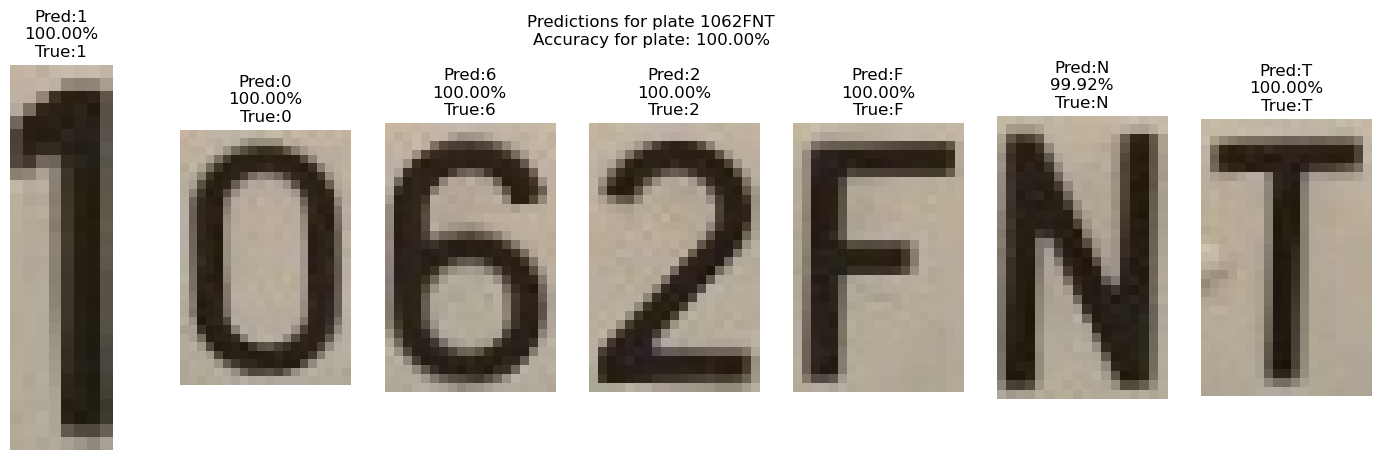

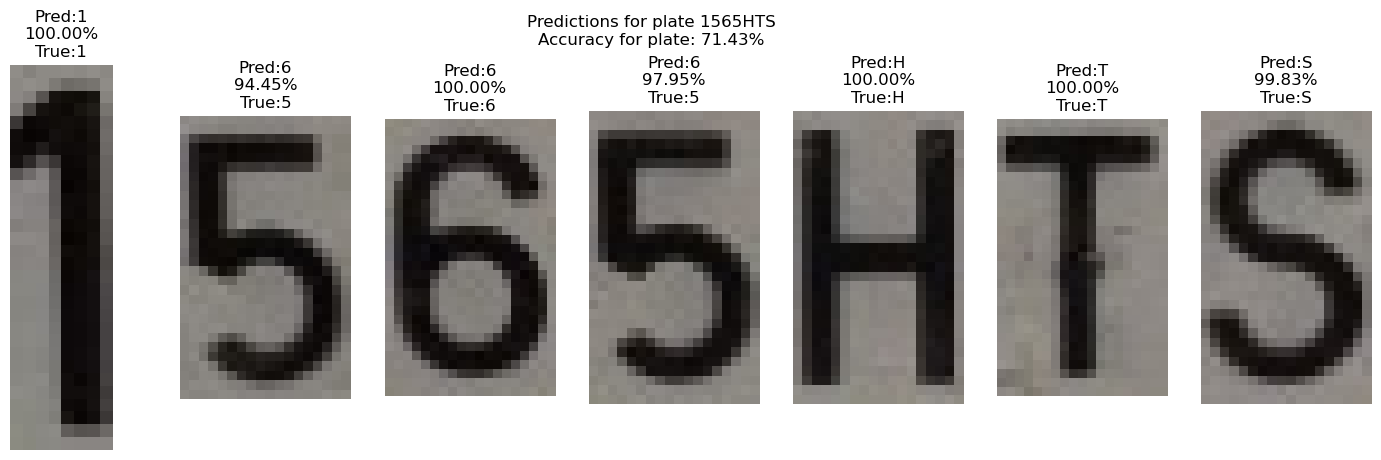

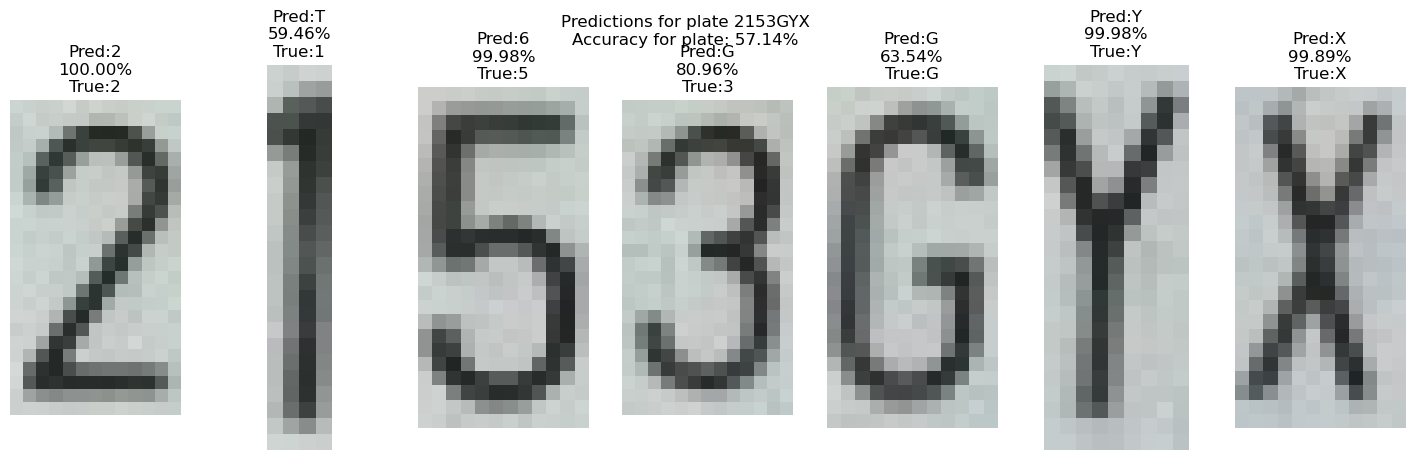

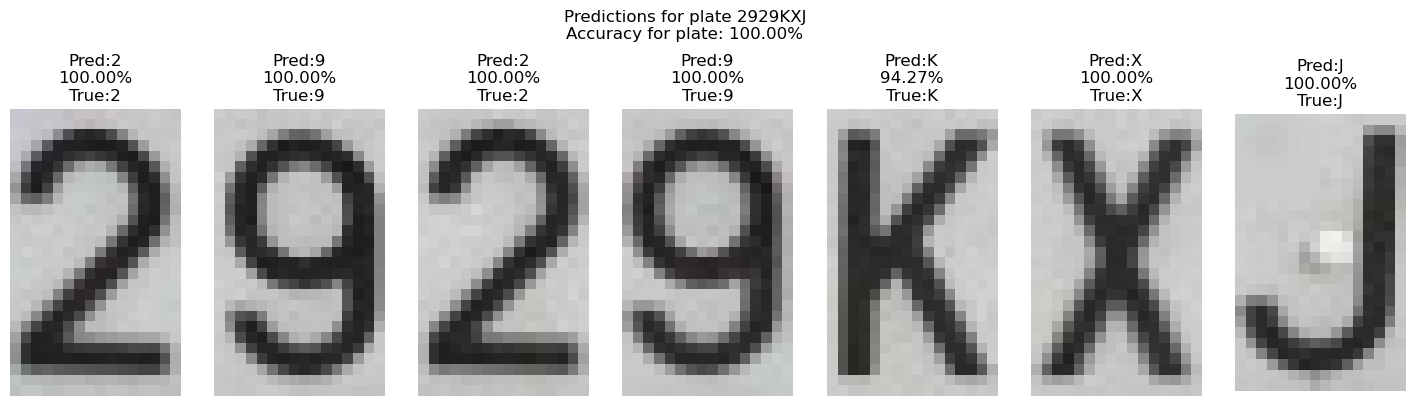

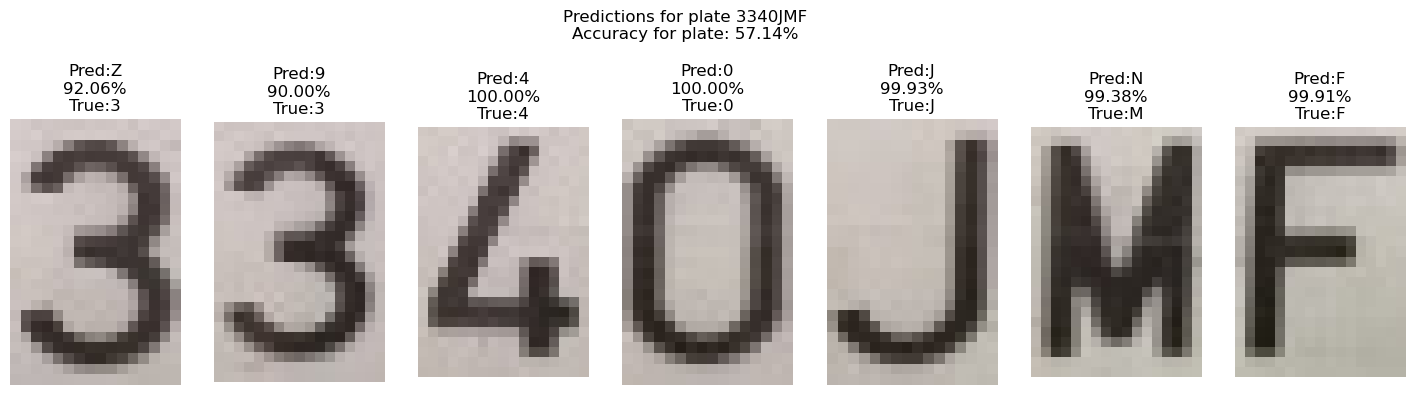

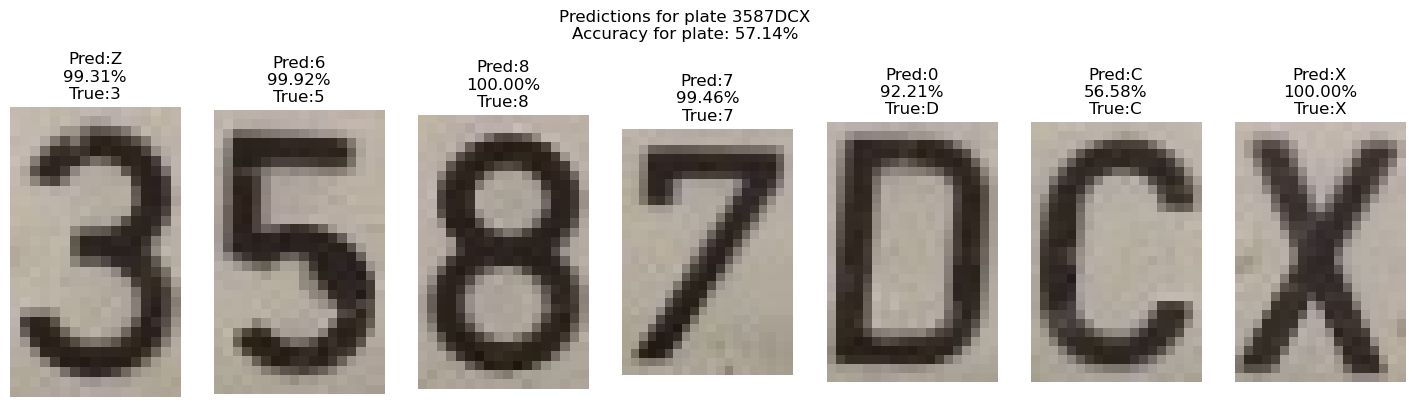

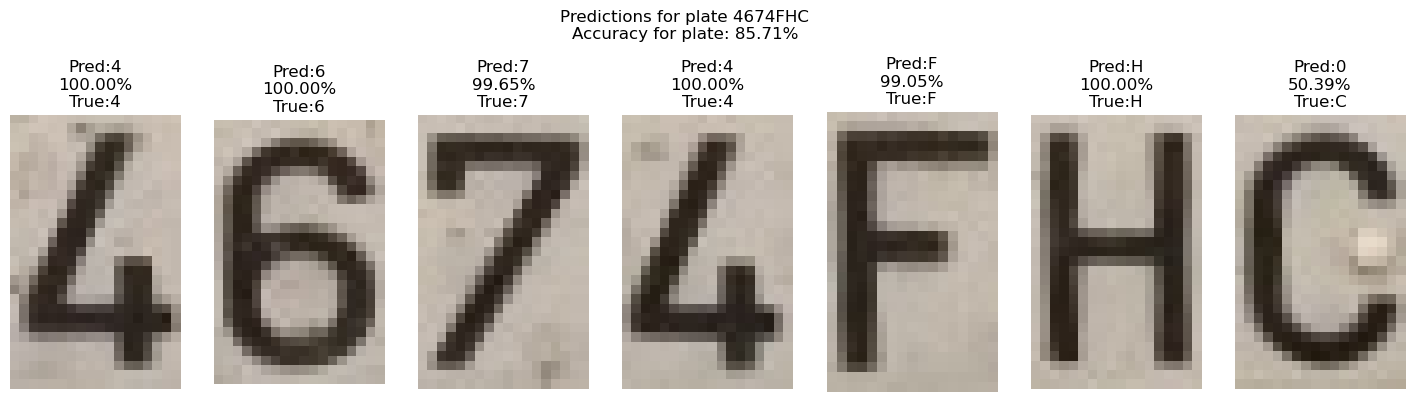

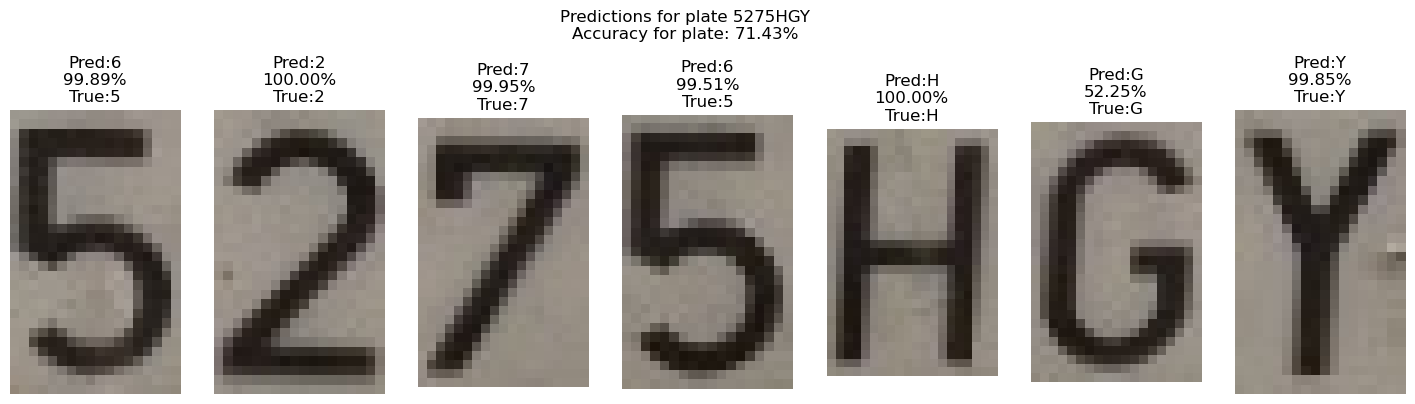

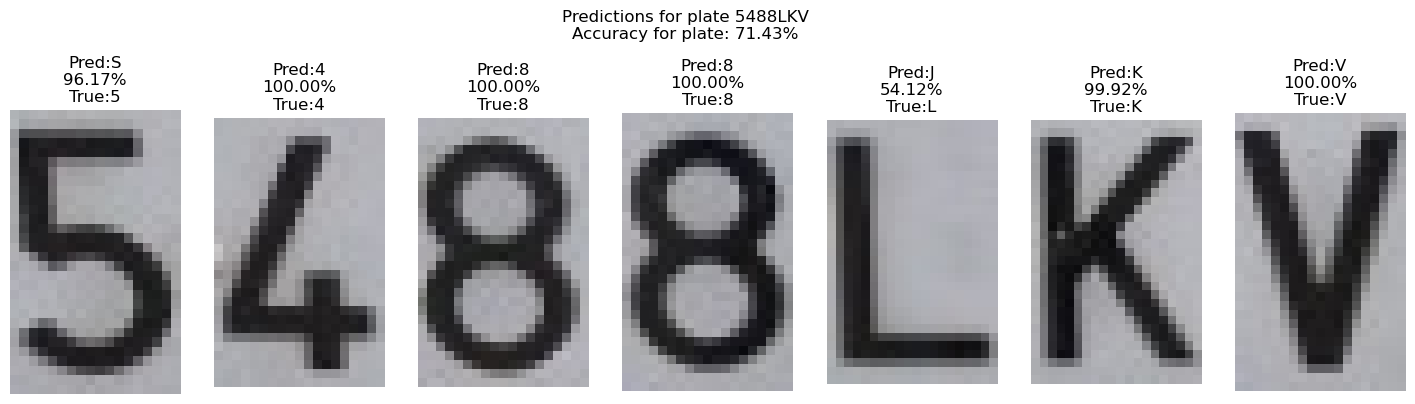

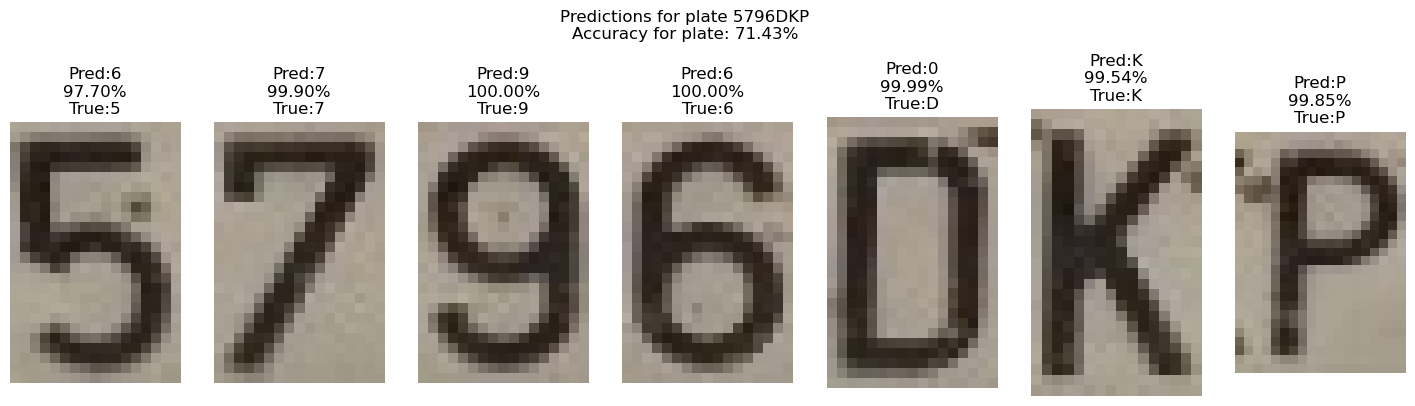

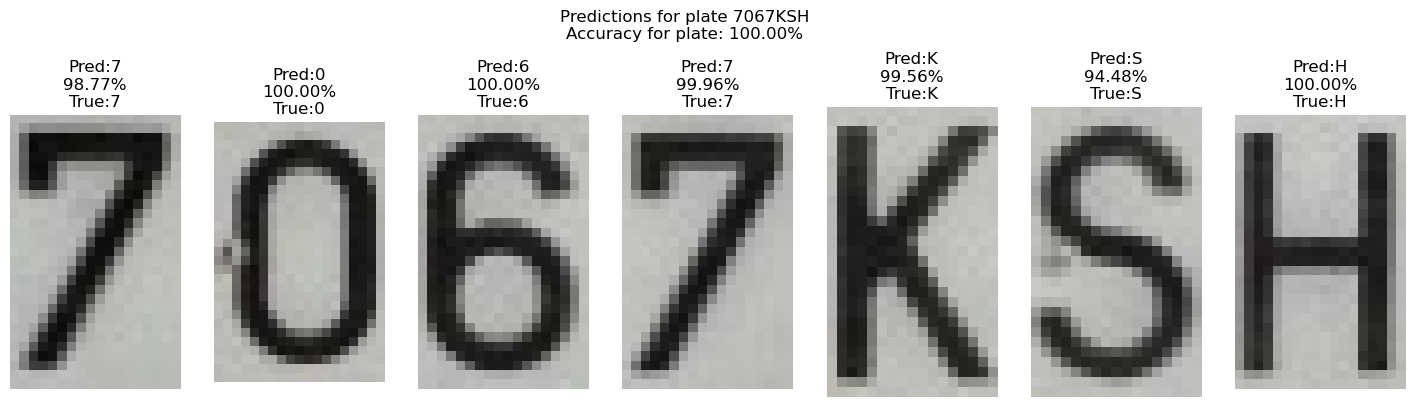

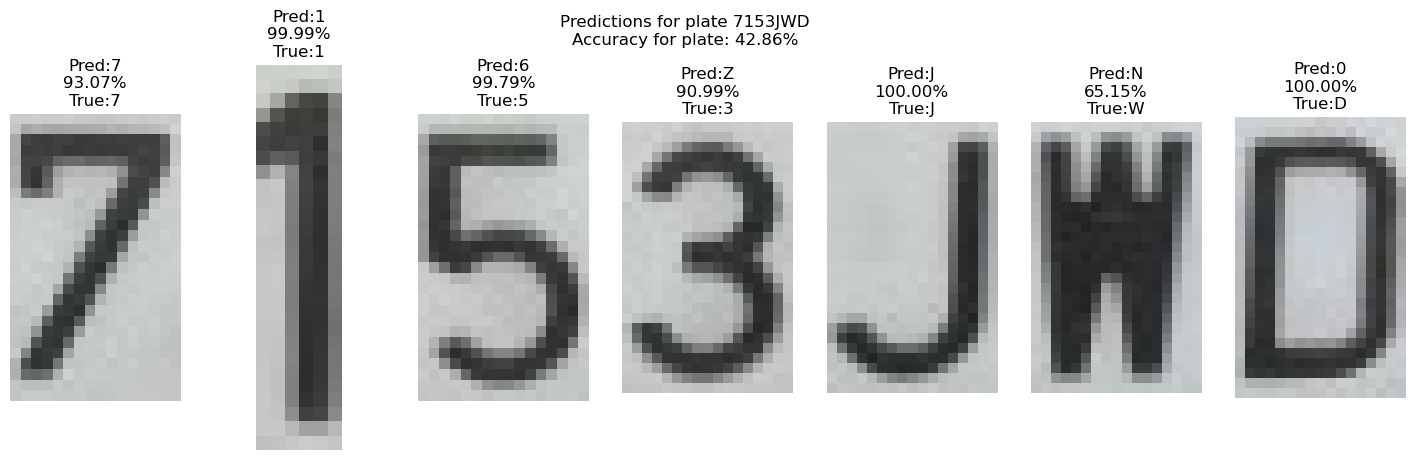

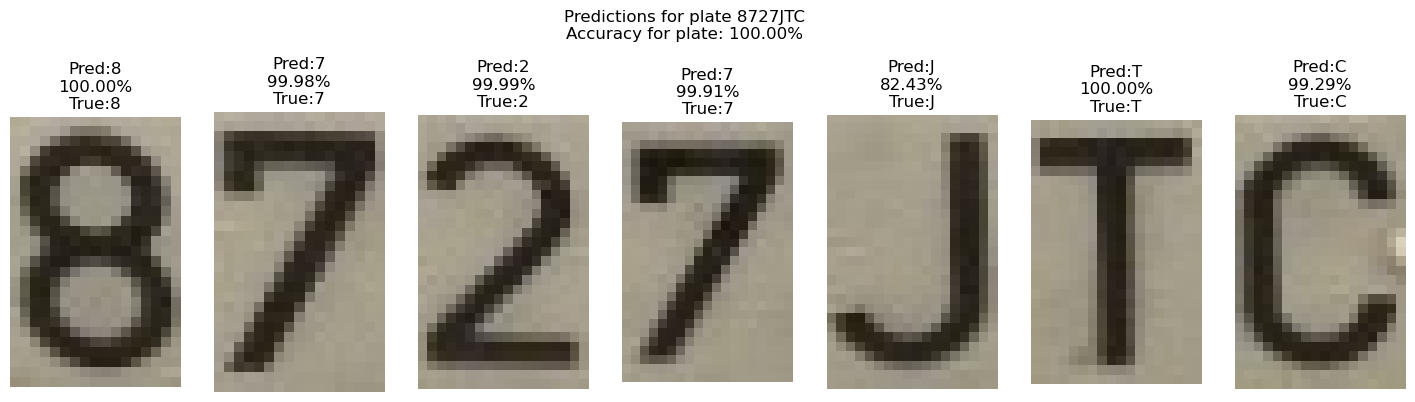

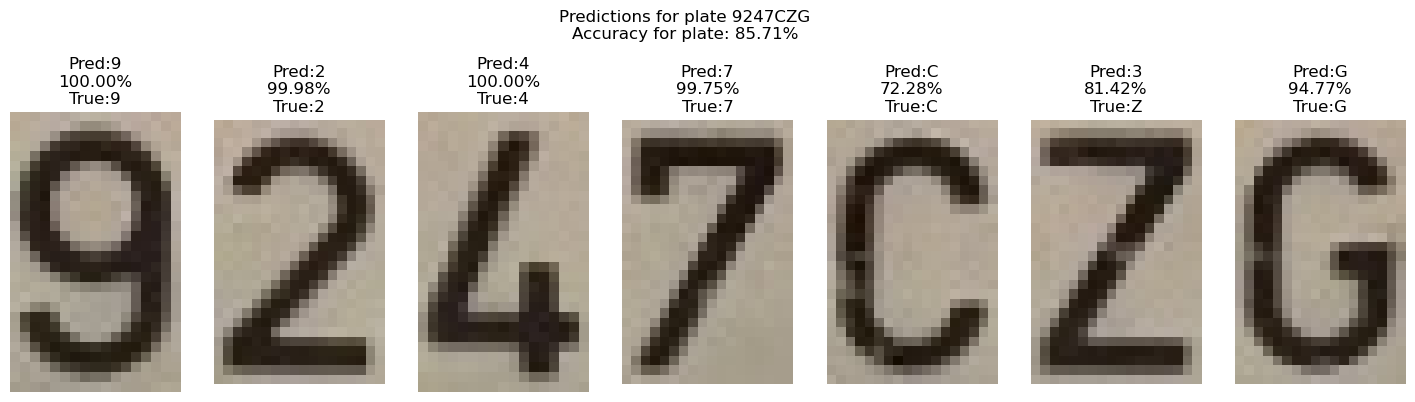

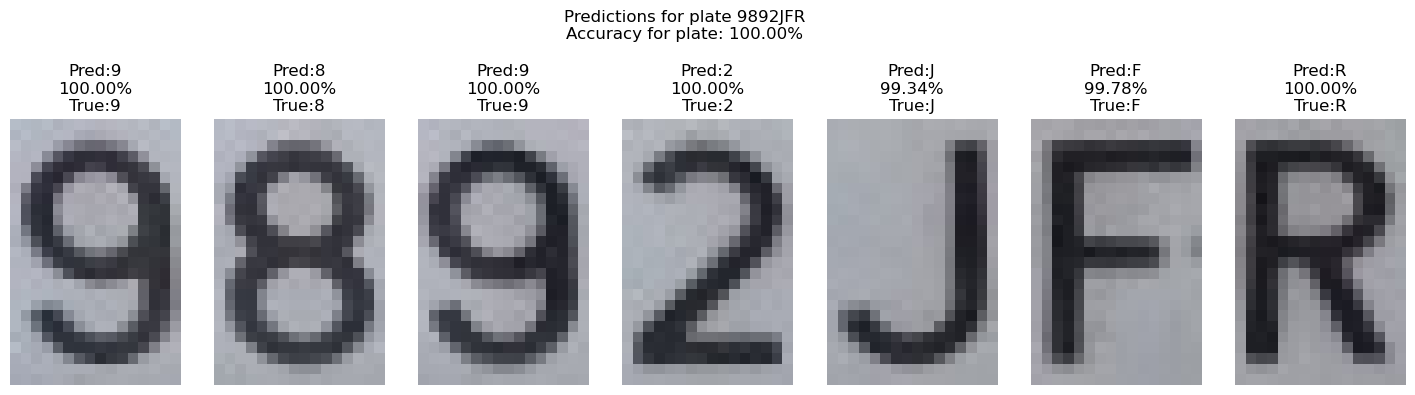

In [127]:
images_path = 'PlateDigits/Frontal/'
correct_digits, correct_plates, total_digits, total_plates = predict(model, images_path)

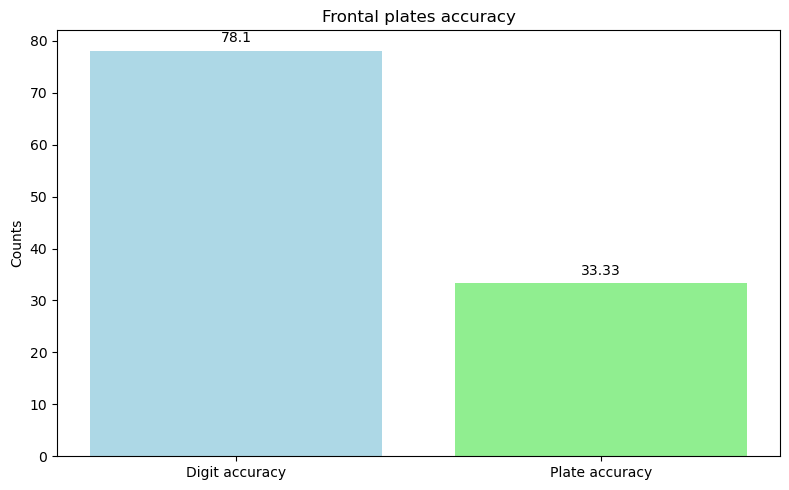

In [129]:
# Bar plot
digit_accuracy_frontal = (correct_digits / total_digits) *100
plate_accuracy_frontal = (correct_plates / total_plates) *100
bar_plot([digit_accuracy_frontal, plate_accuracy_frontal],
         categories = ['Digit accuracy', 'Plate accuracy'],
         type="Frontal",colors = ['lightblue','lightgreen'])

### Lateral plates

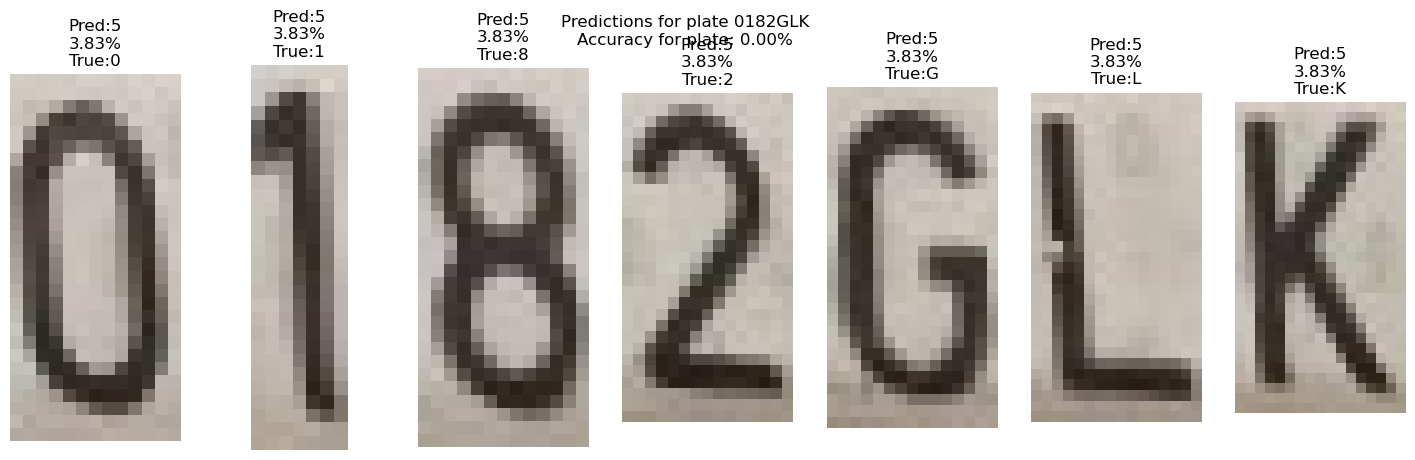

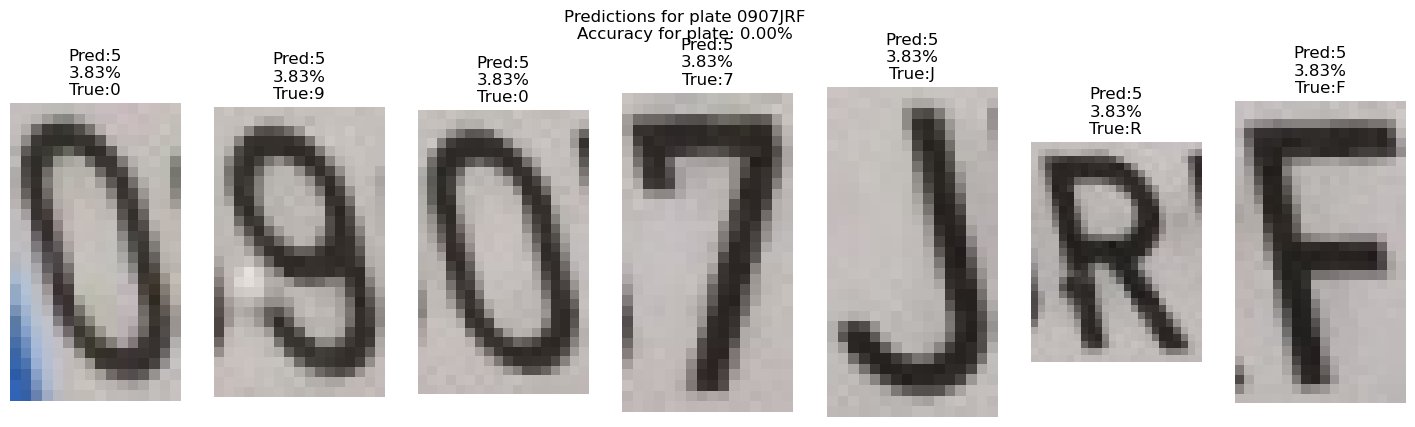

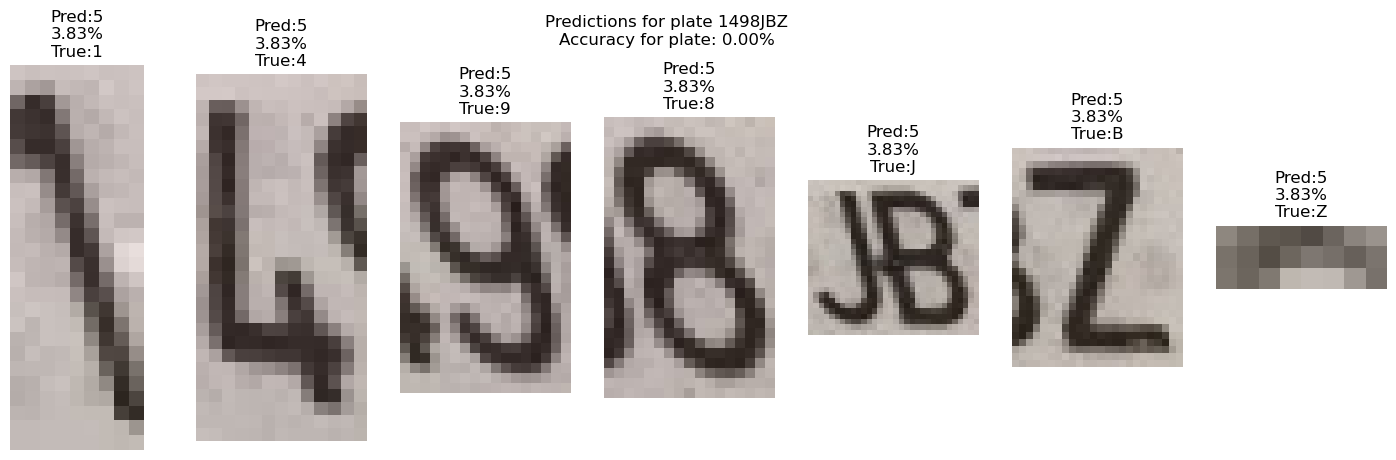

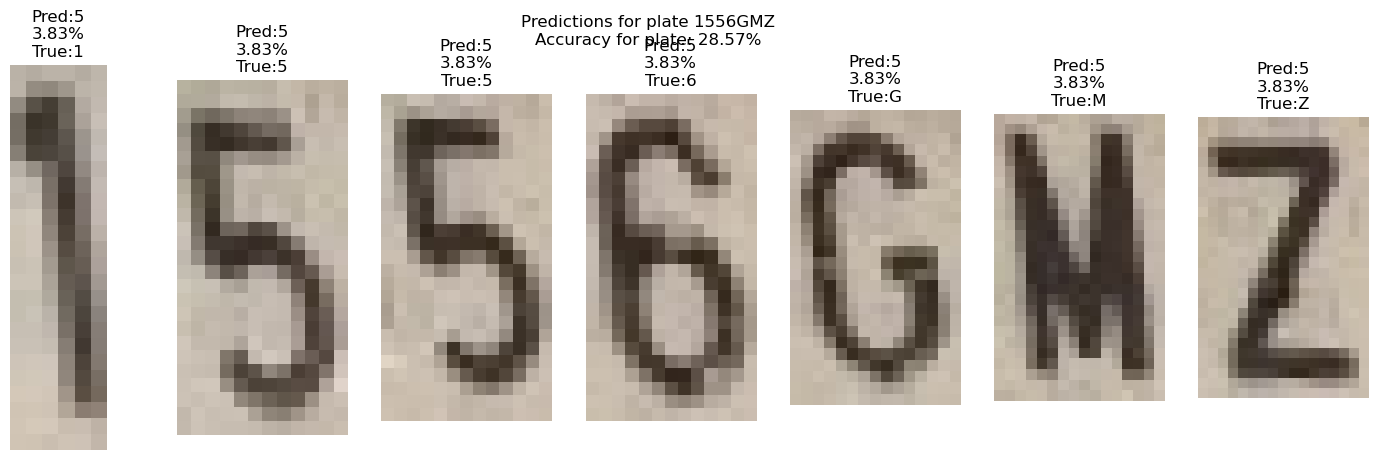

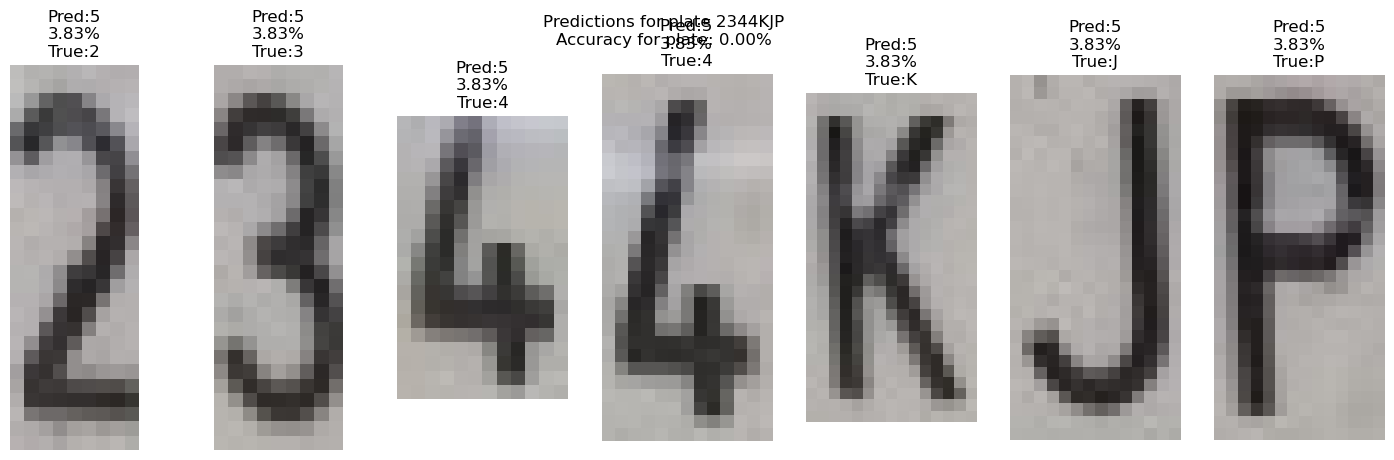

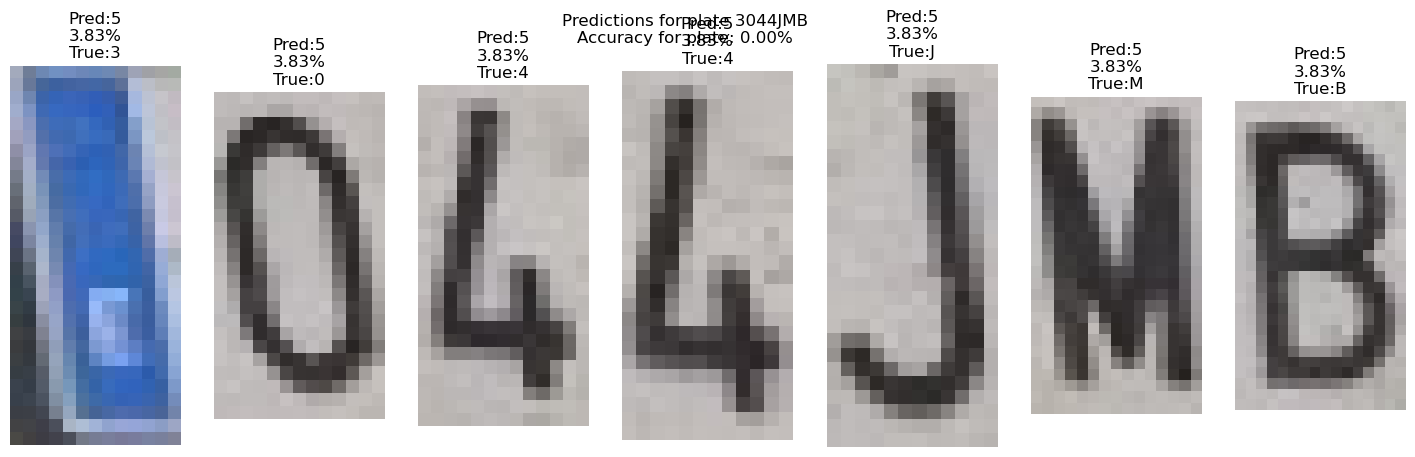

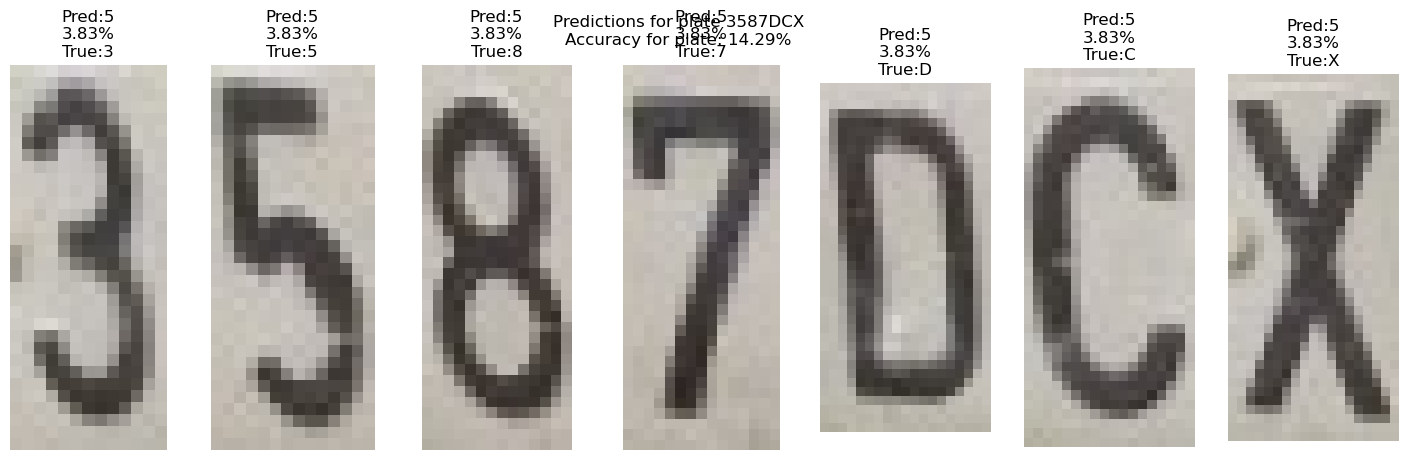

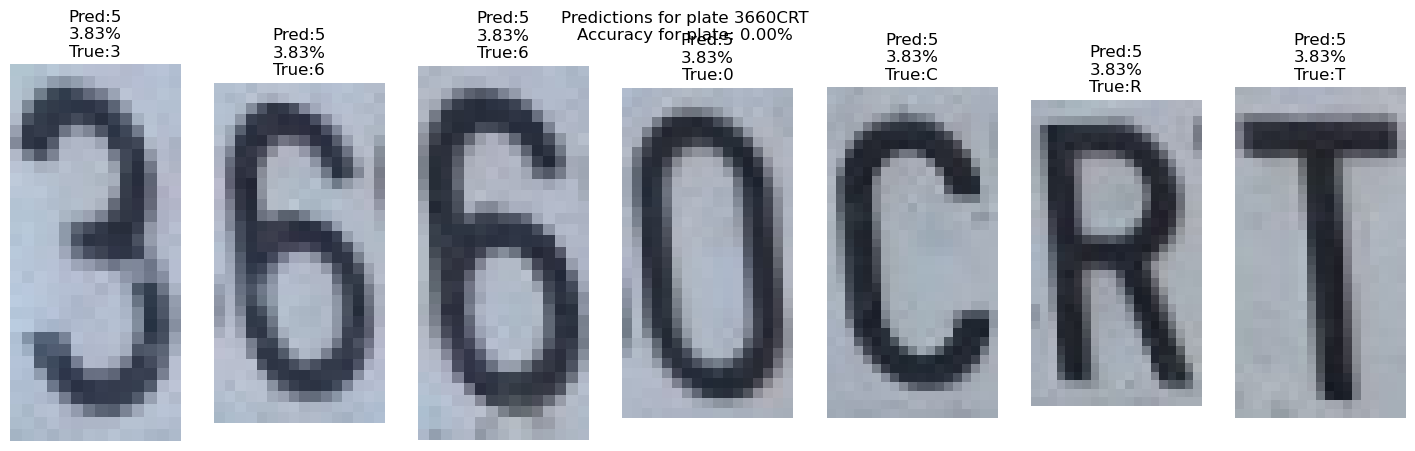

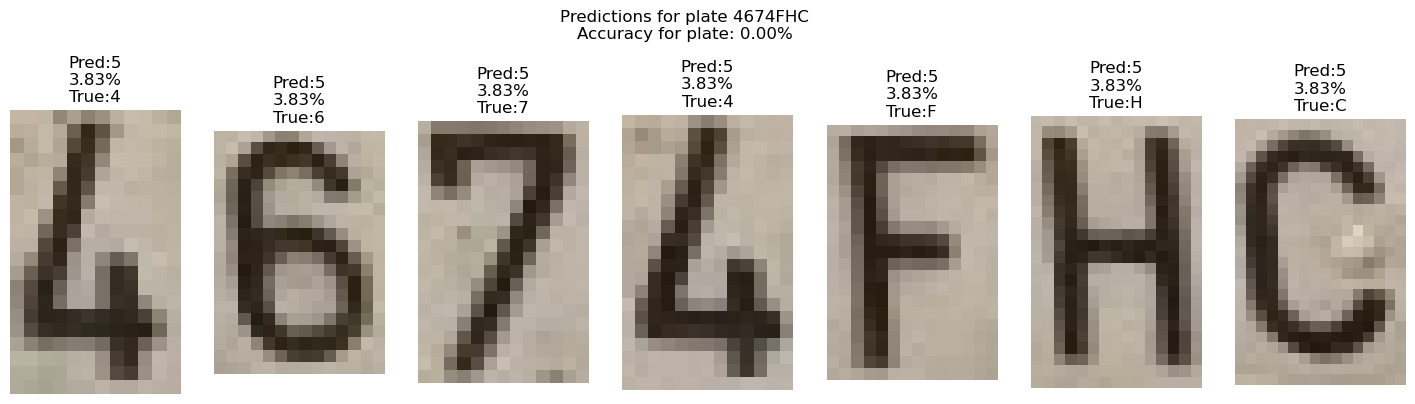

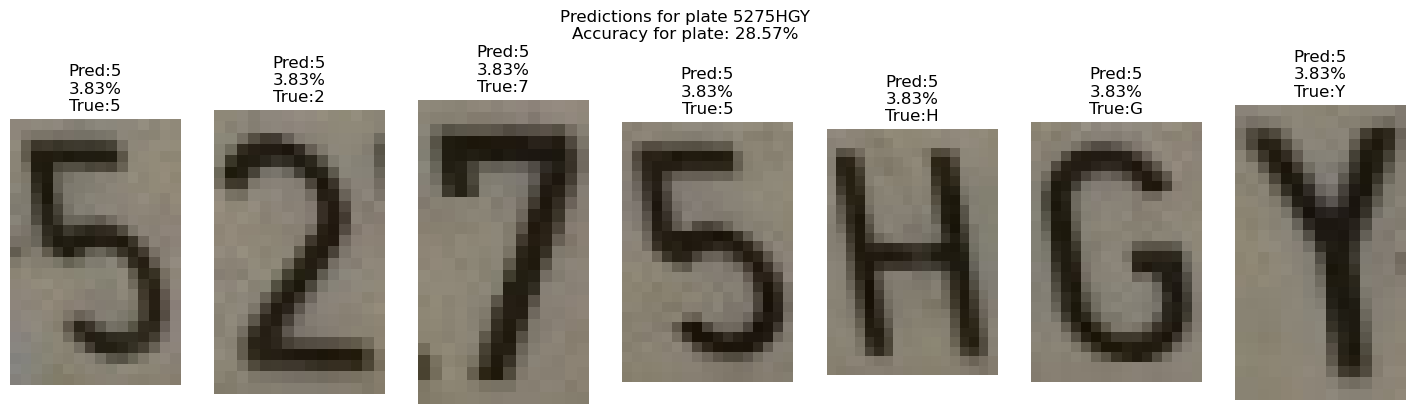

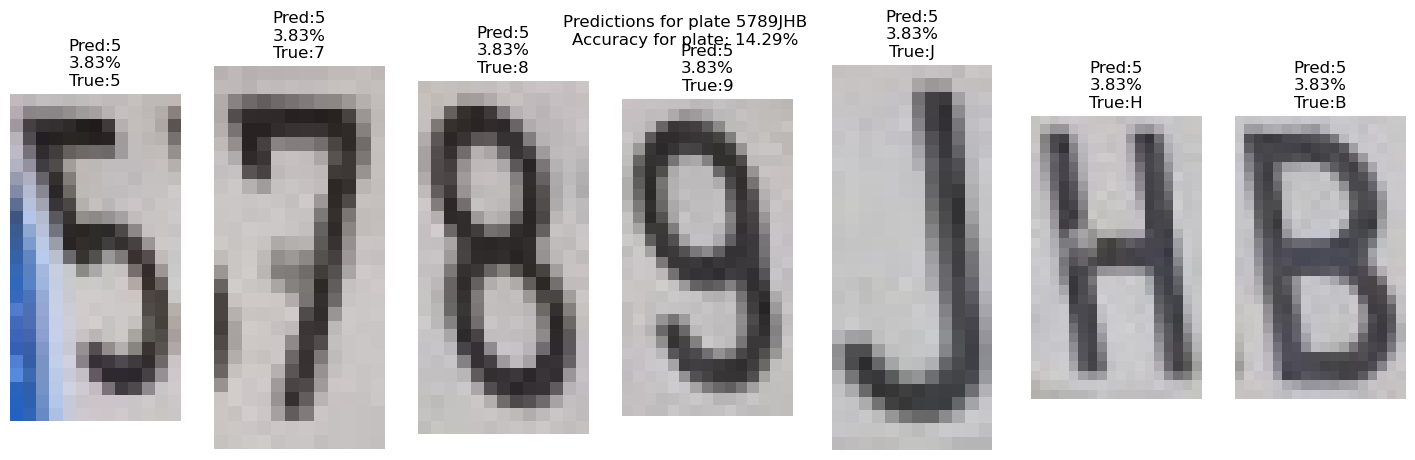

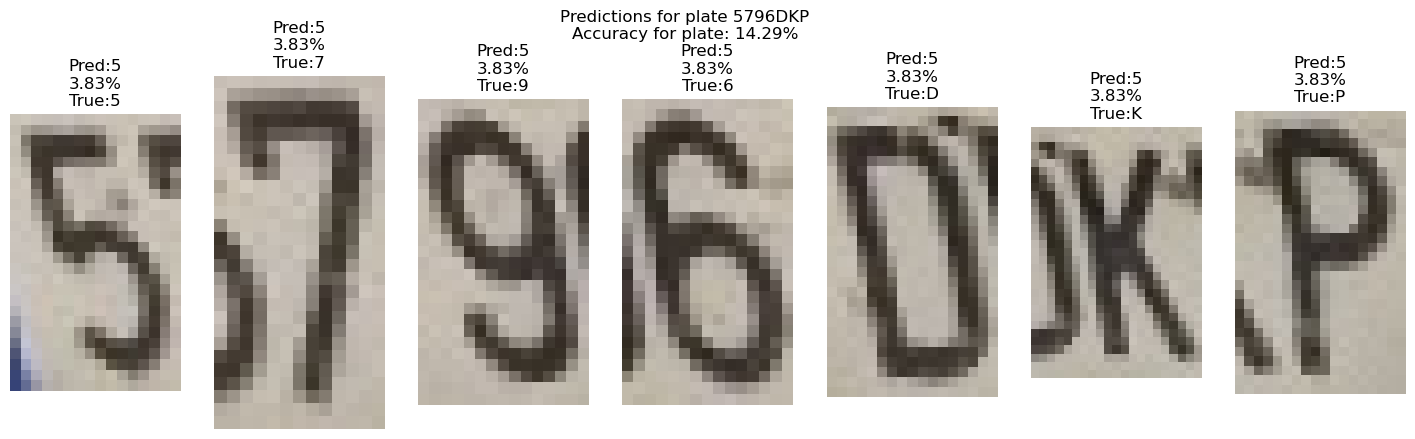

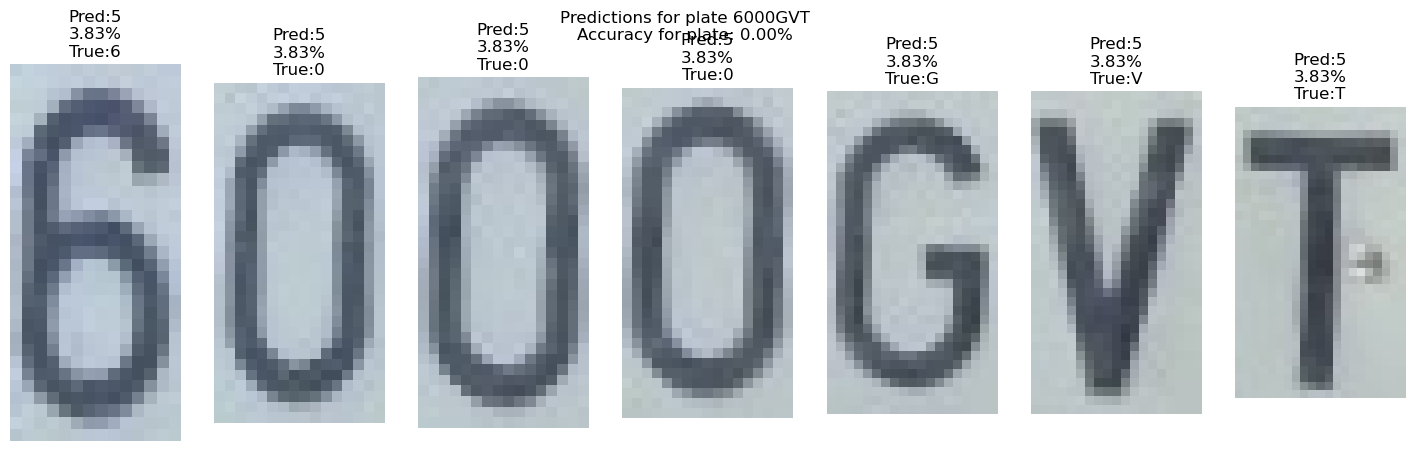

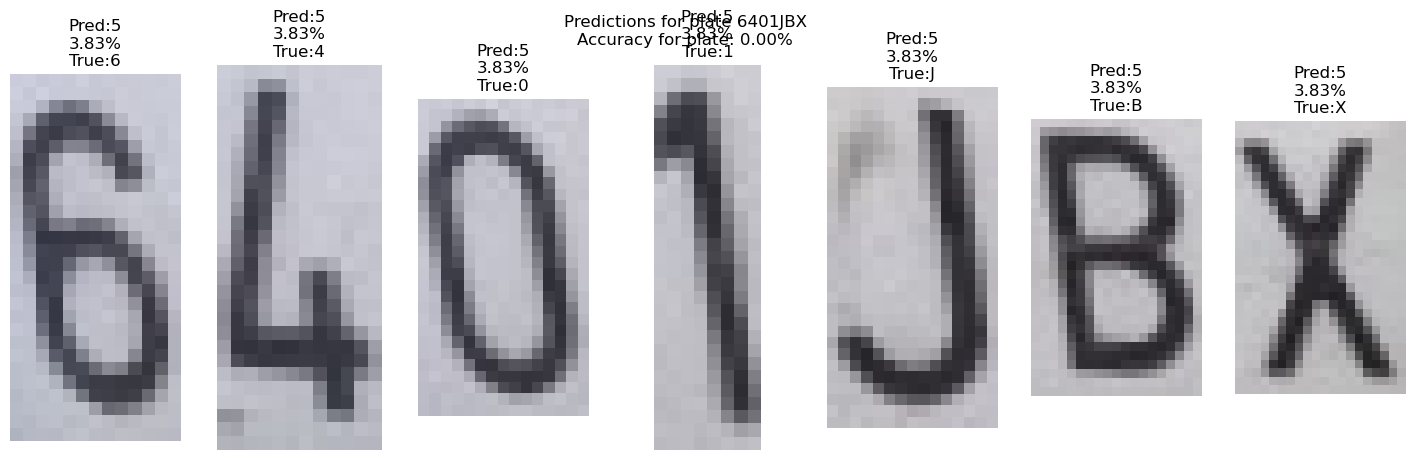

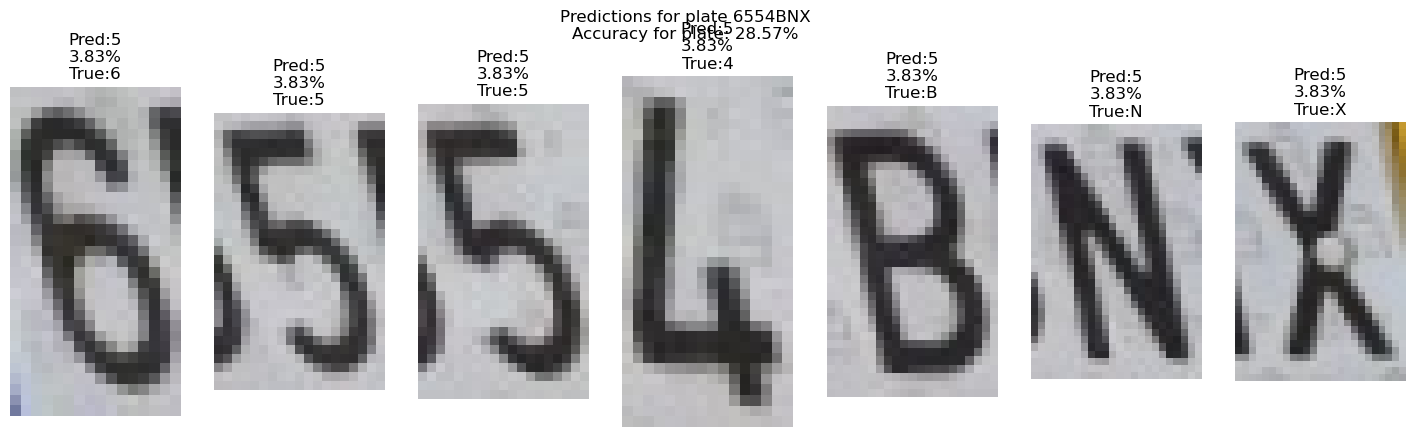

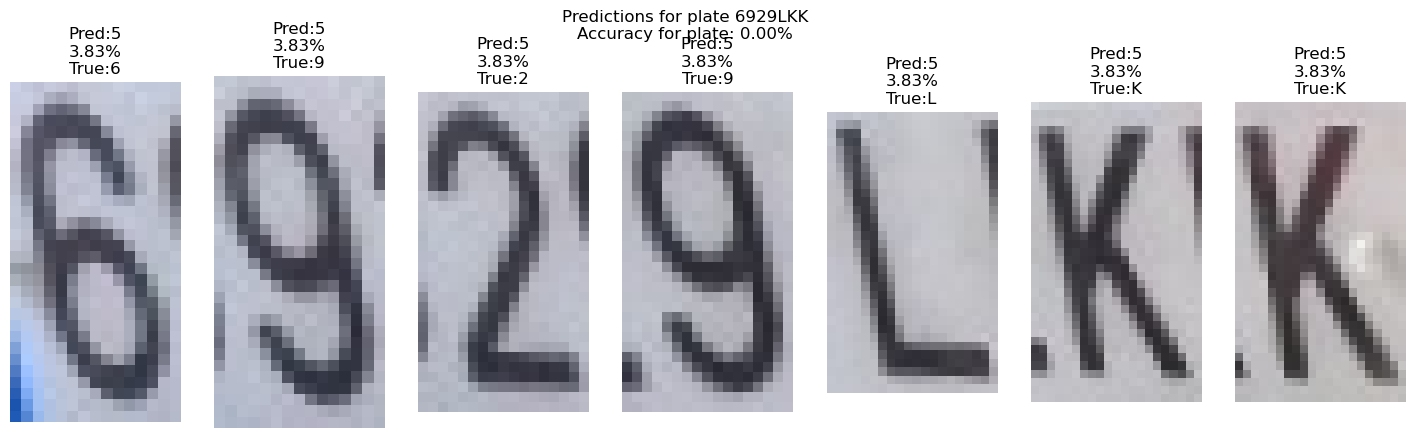

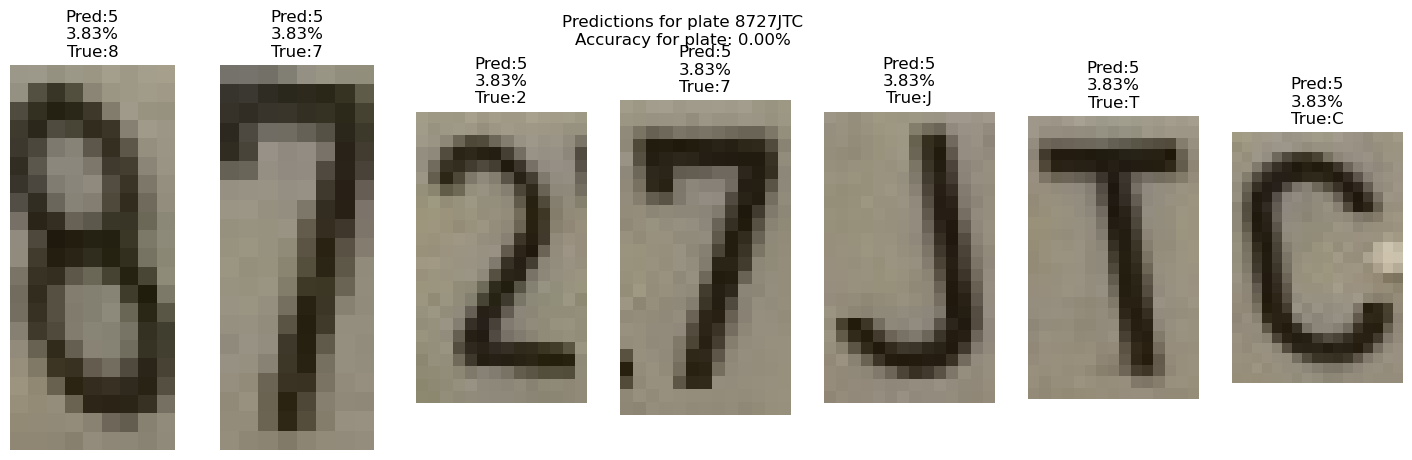

In [101]:
images_path = 'PlateDigits/Lateral/'
correct_digits, correct_plates, total_digits, total_plates = predict(model, images_path)

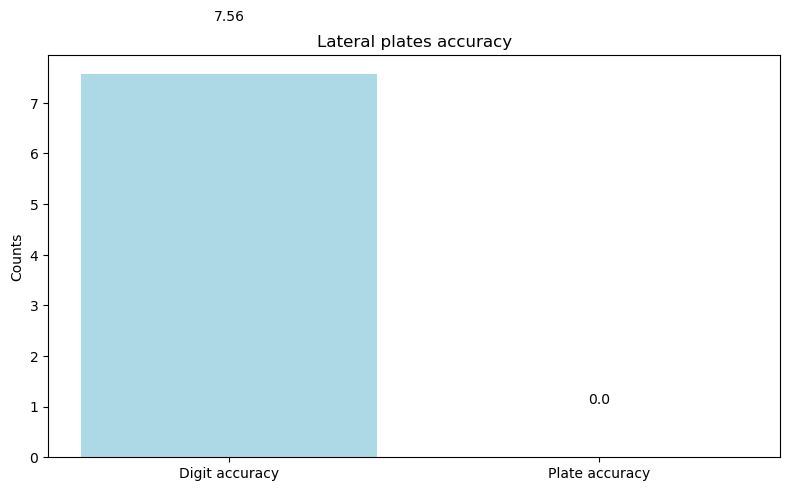

In [102]:
# Bar plot
digit_accuracy_lateral = (correct_digits / total_digits) *100
plate_accuracy_lateral = (correct_plates / total_plates) *100
bar_plot(values=[digit_accuracy_lateral, plate_accuracy_lateral],
         categories = ['Digit accuracy', 'Plate accuracy'],
         type="Lateral",colors = ['lightblue','lightgreen'])

### Extra dataset

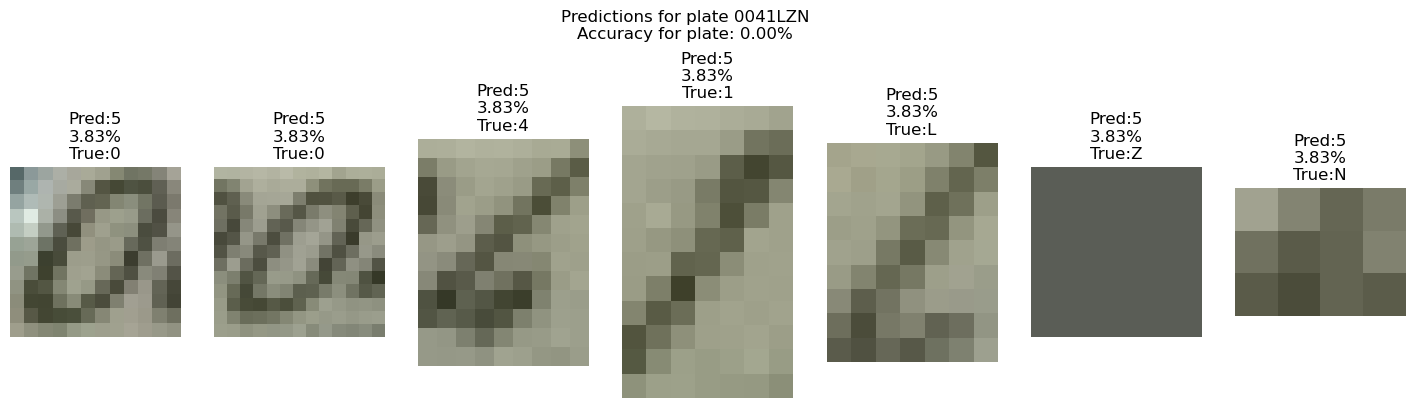

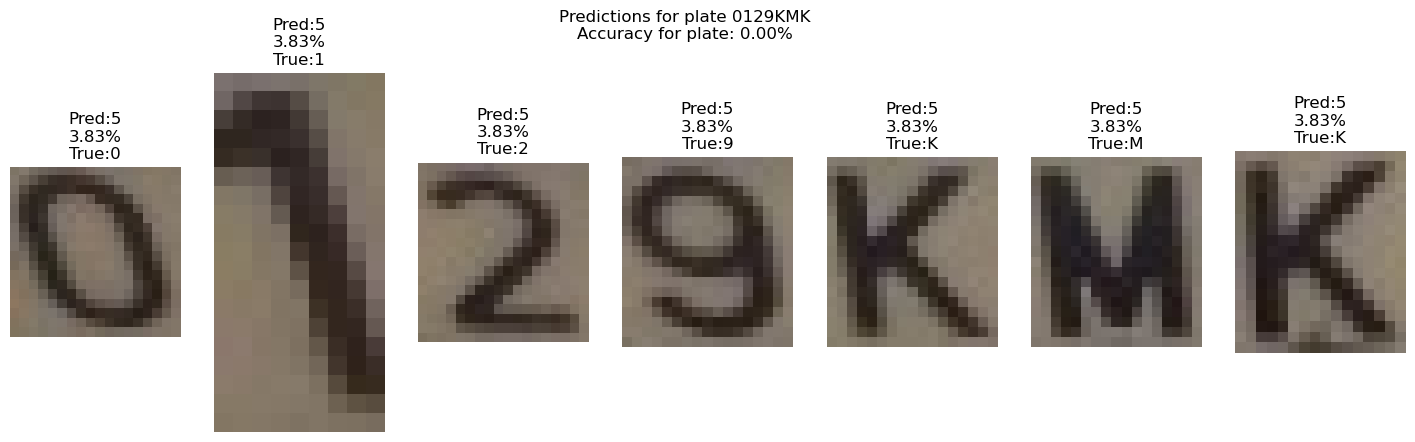

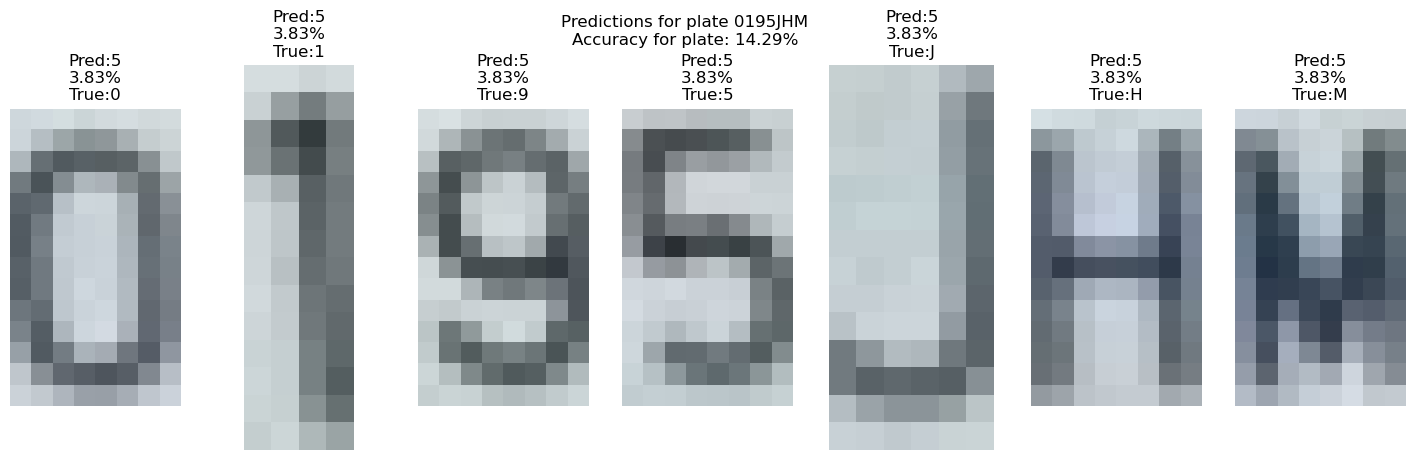

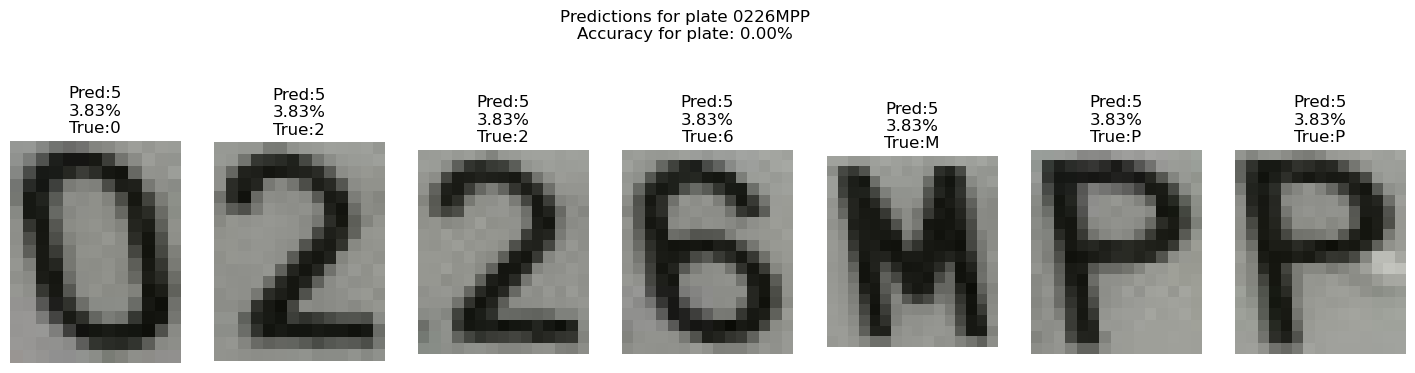

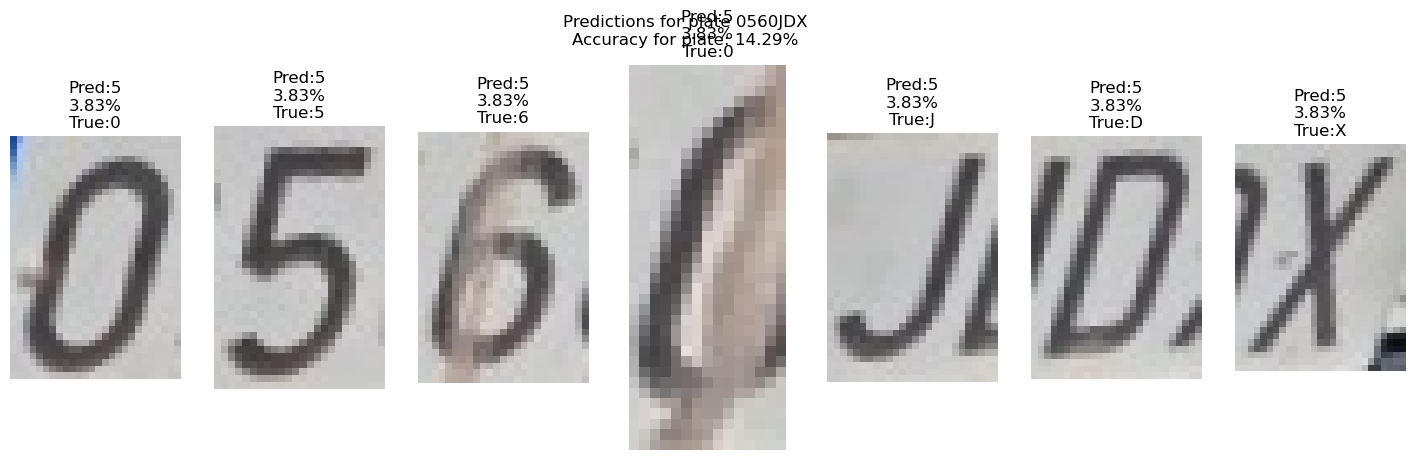

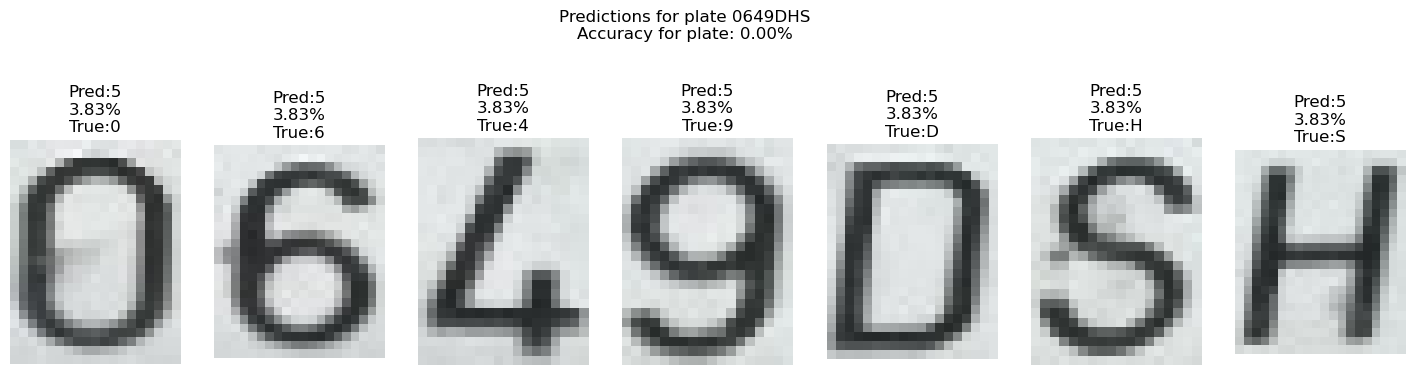

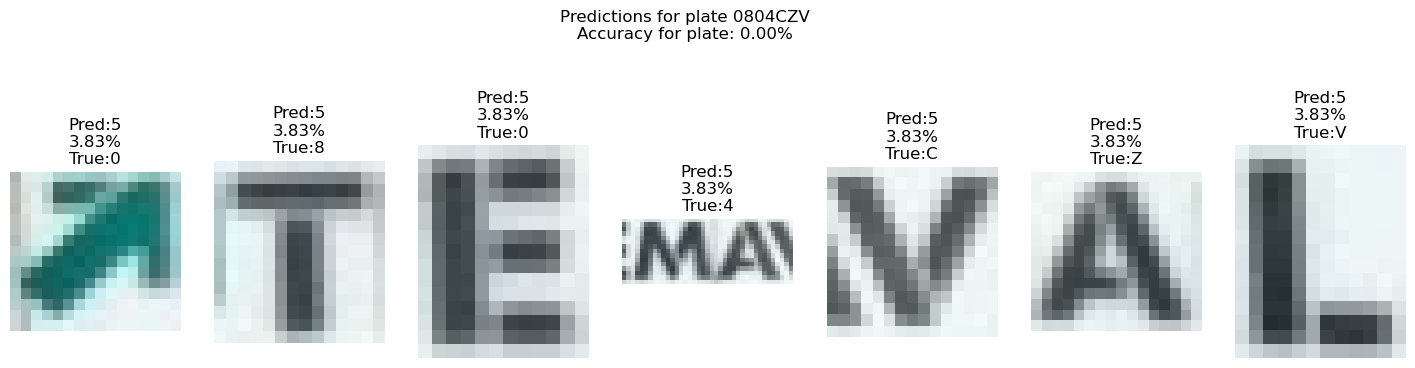

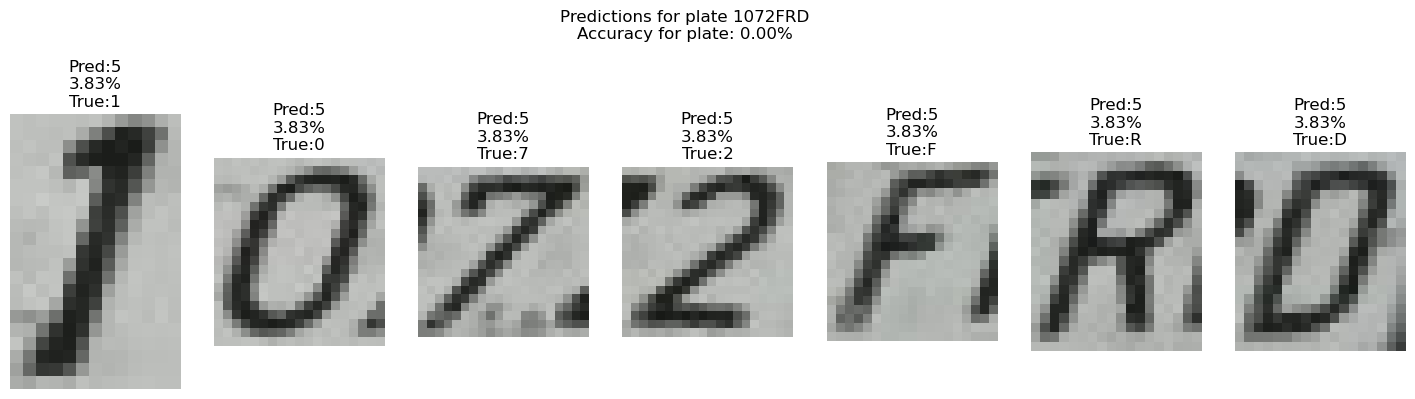

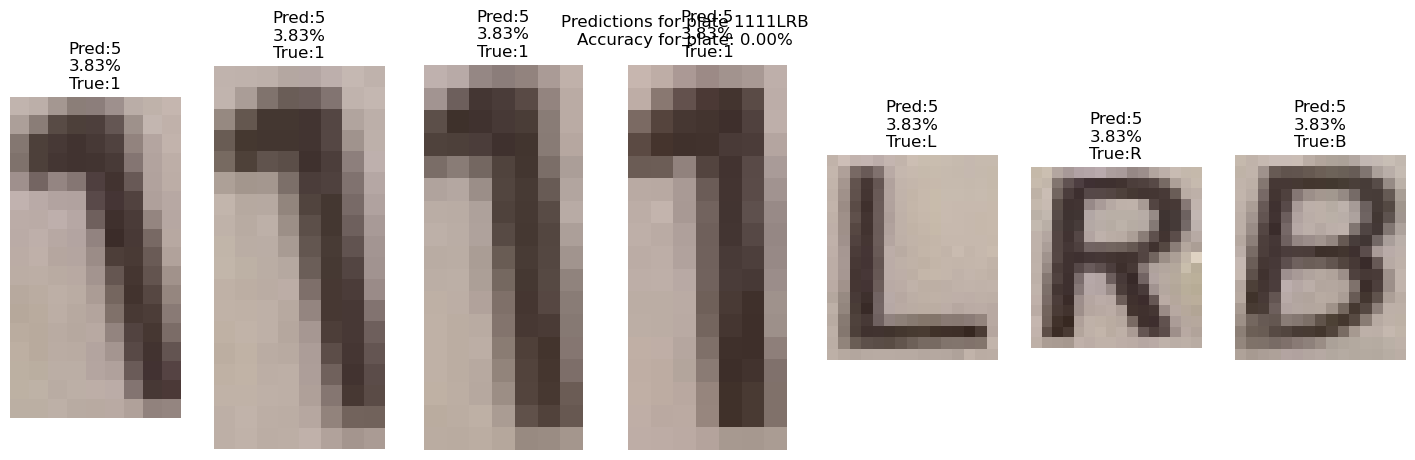

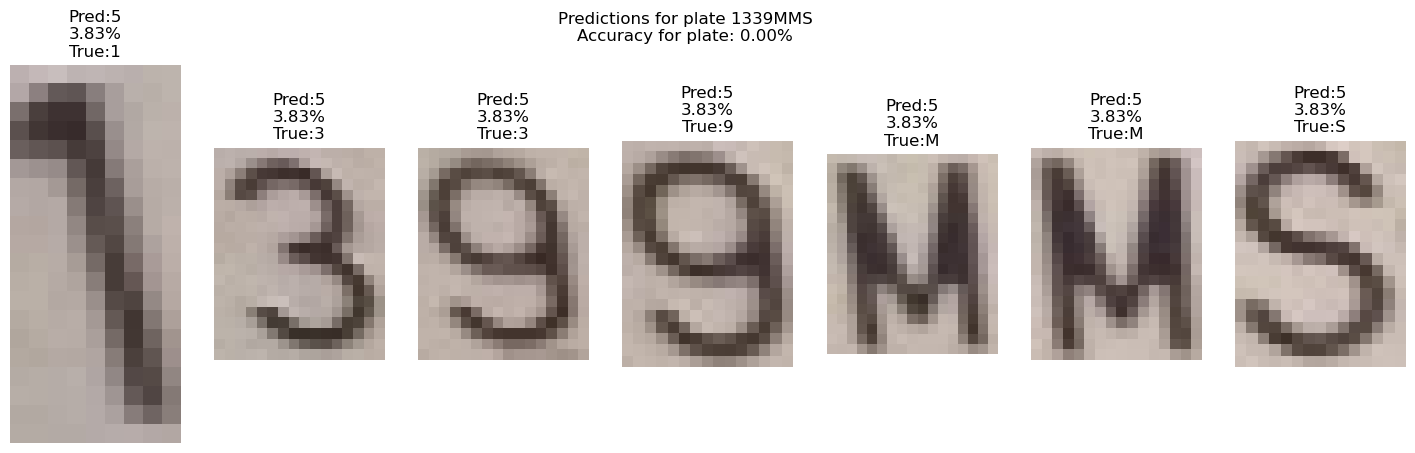

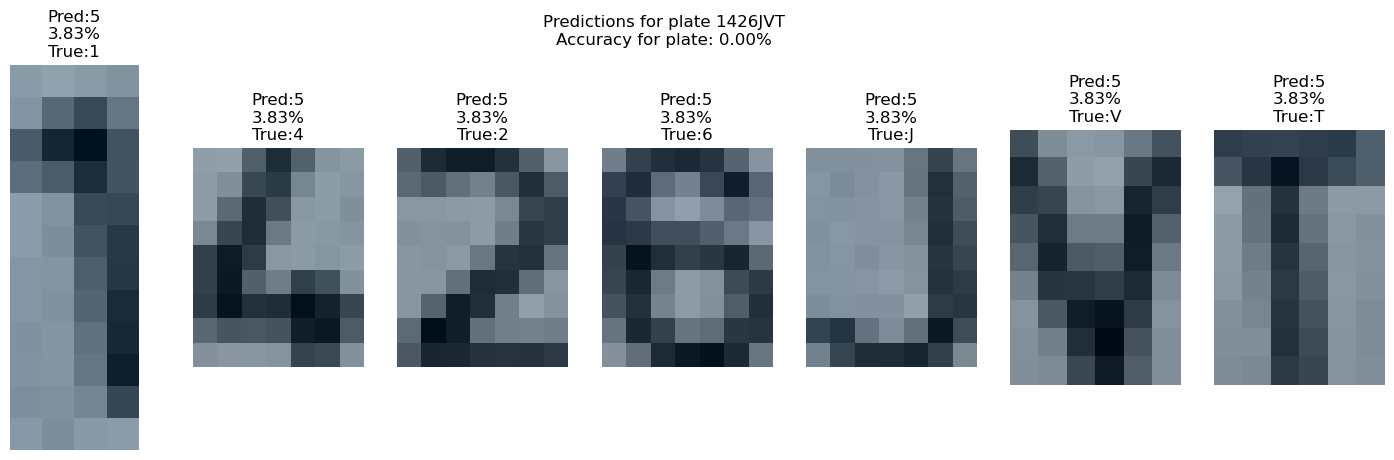

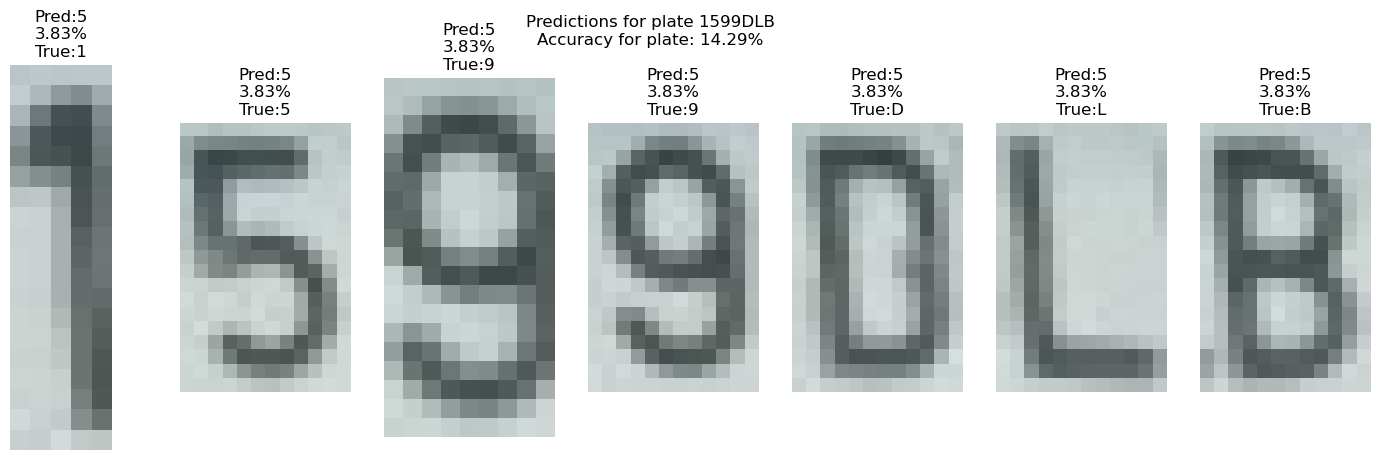

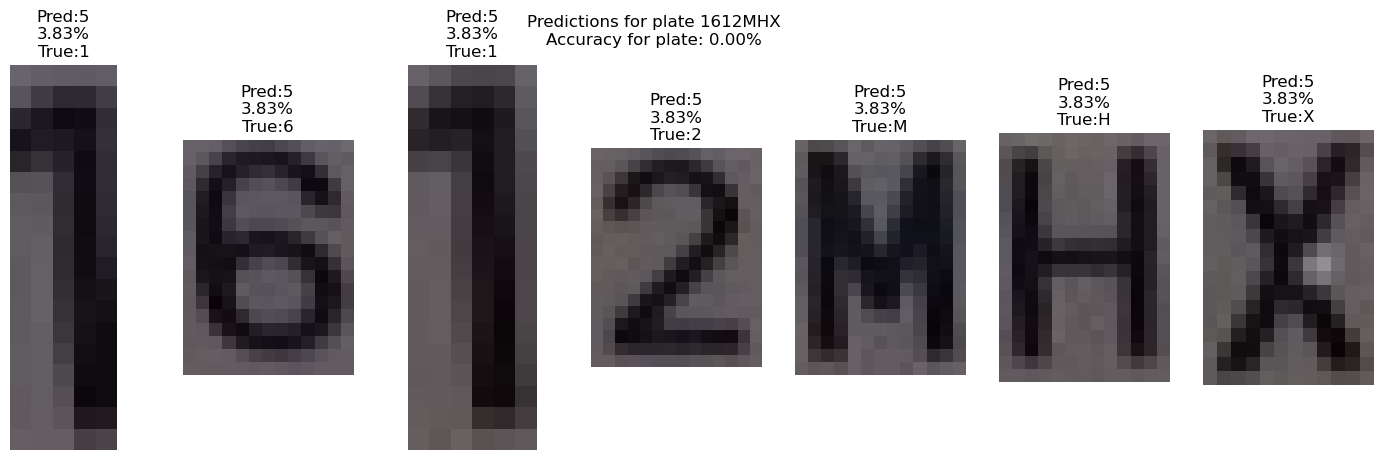

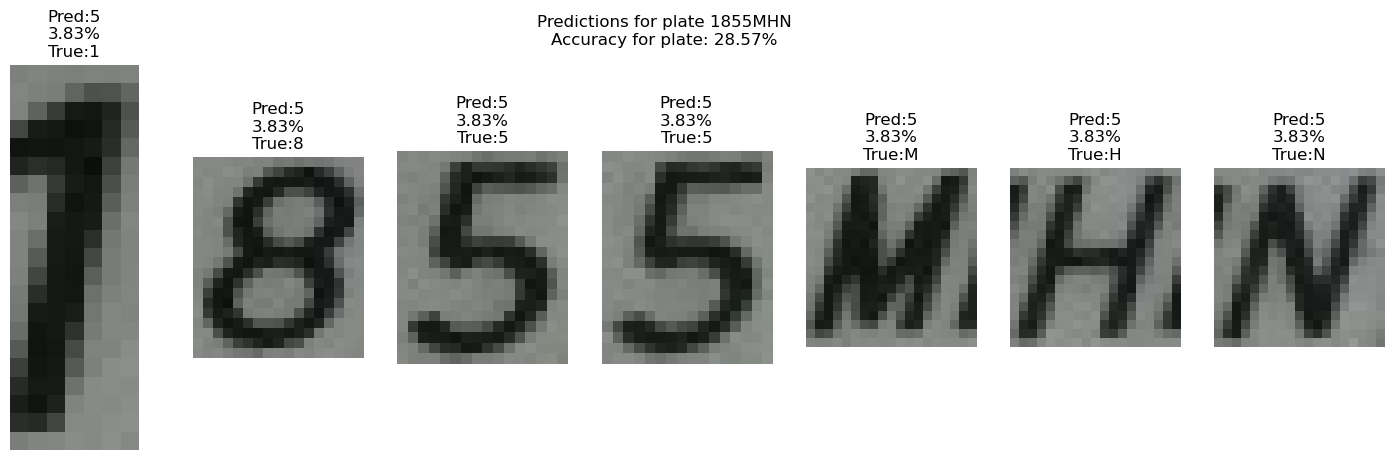

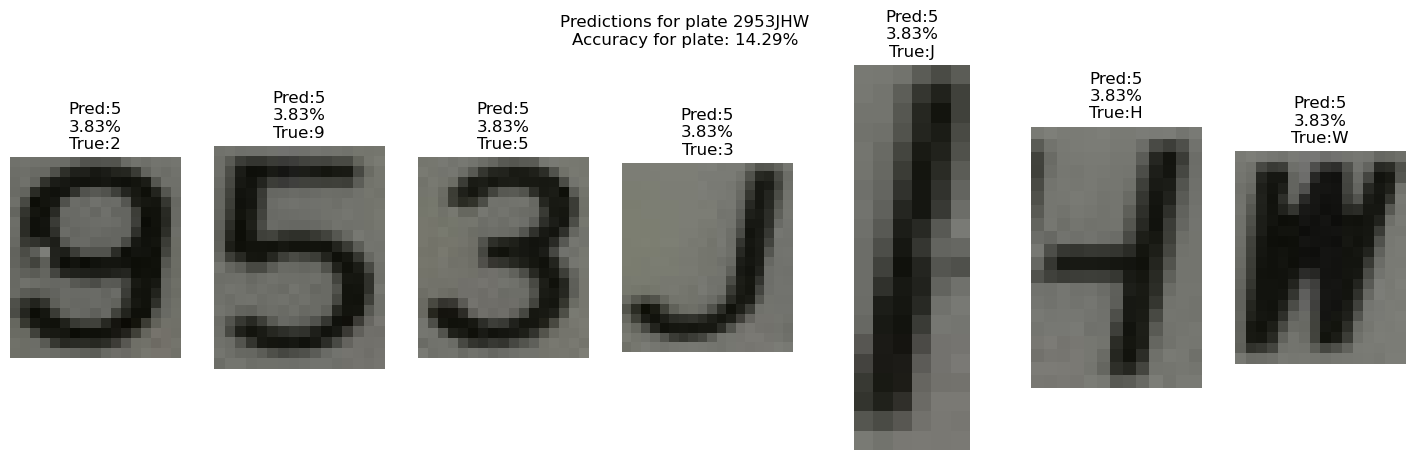

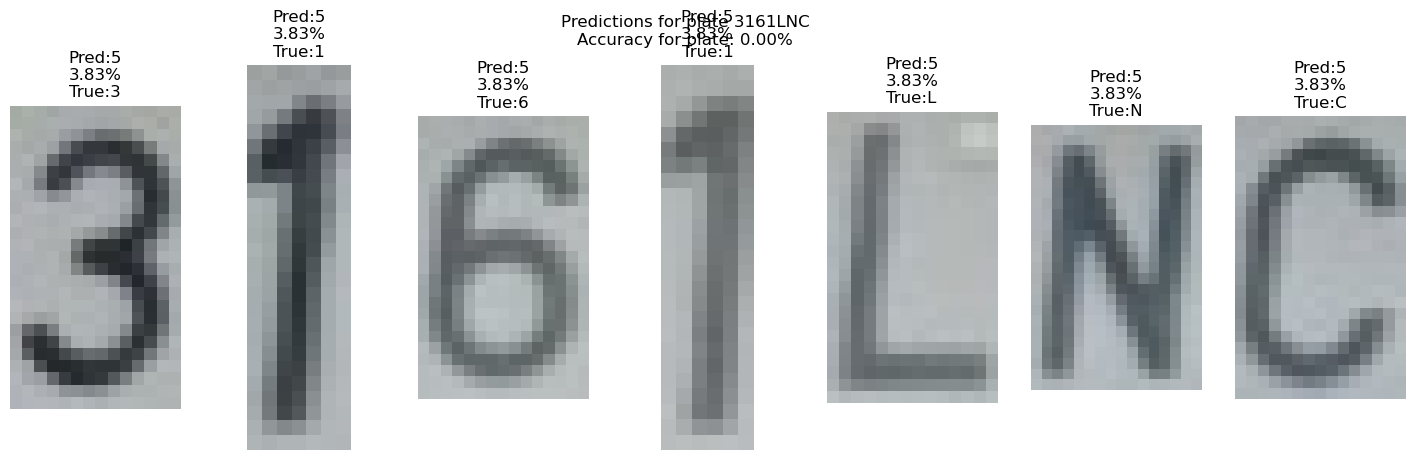

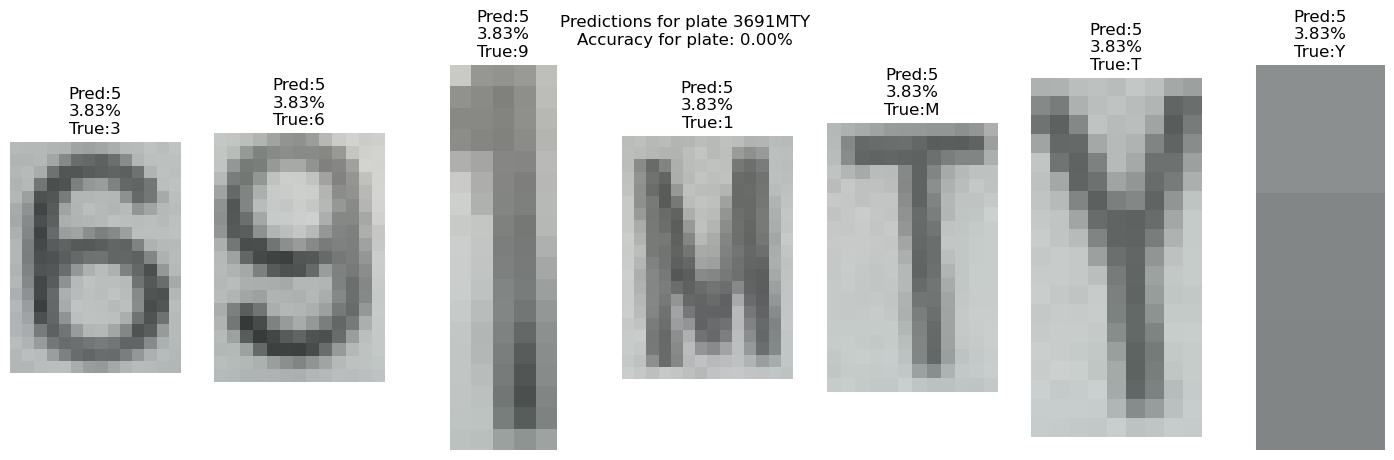

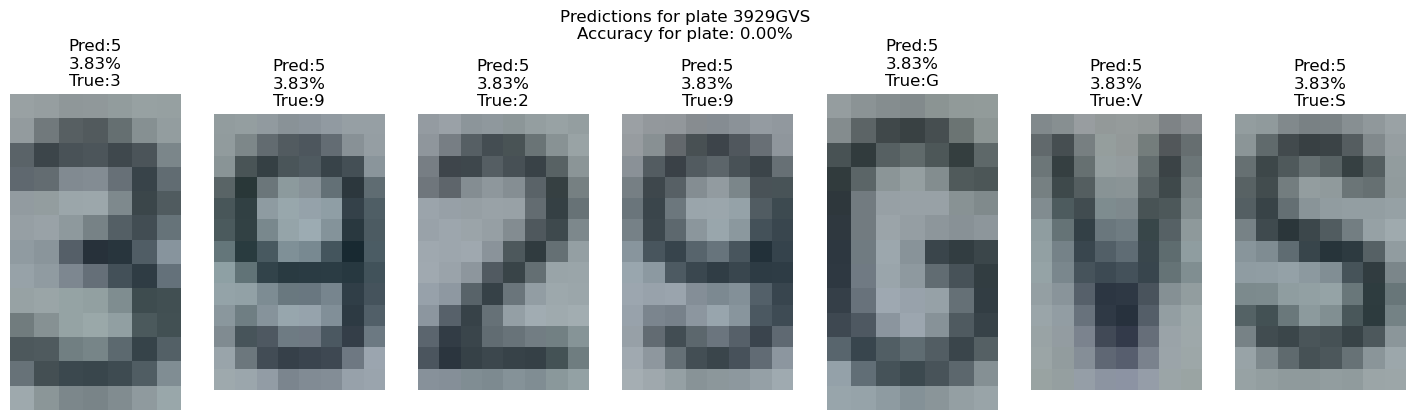

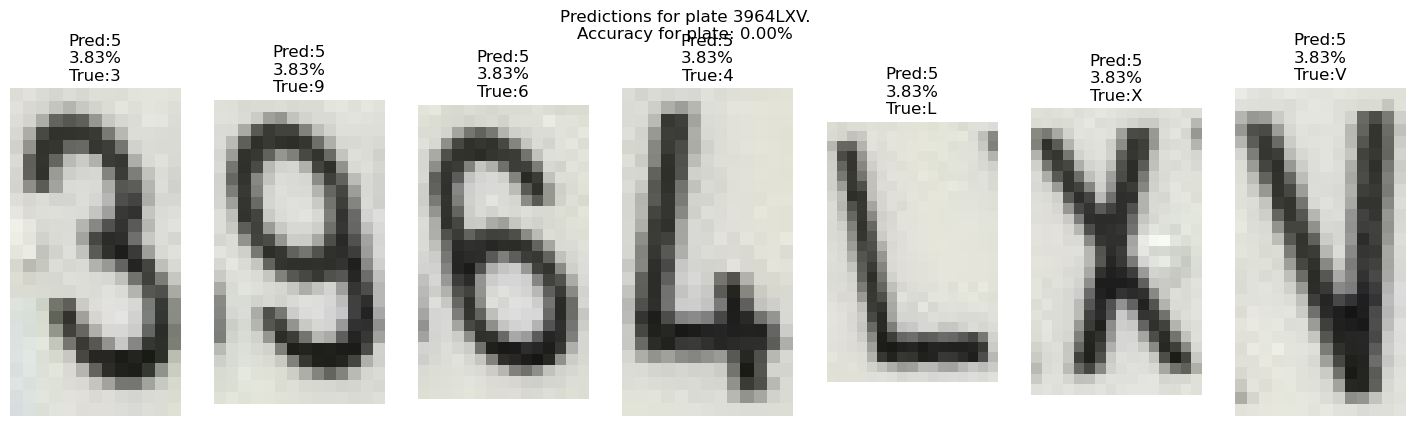

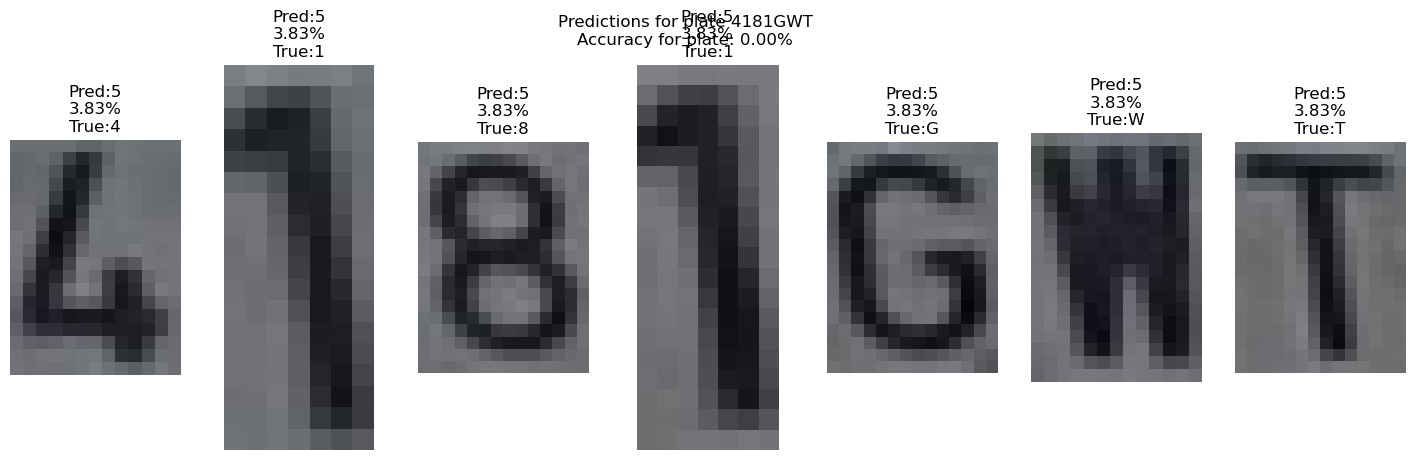

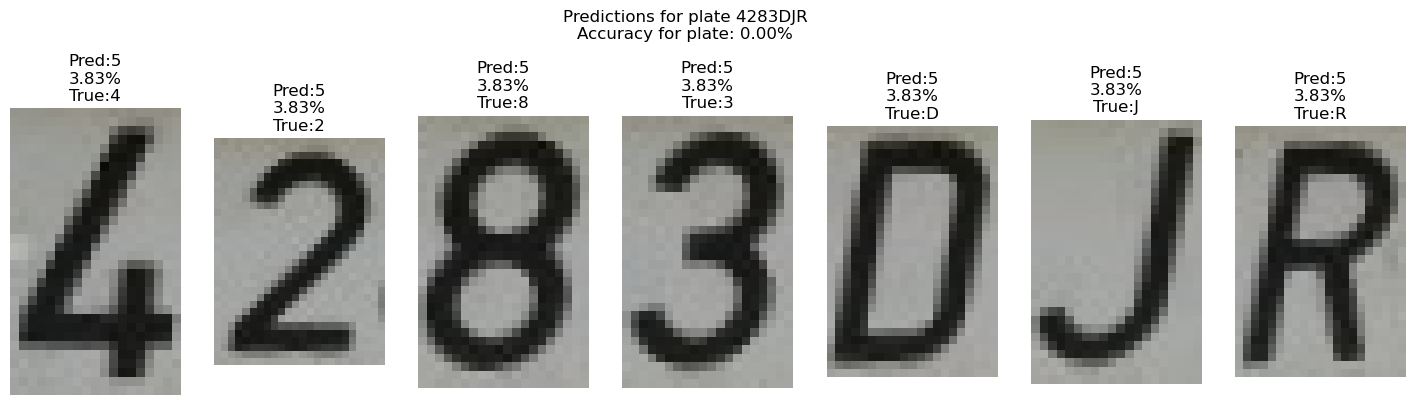

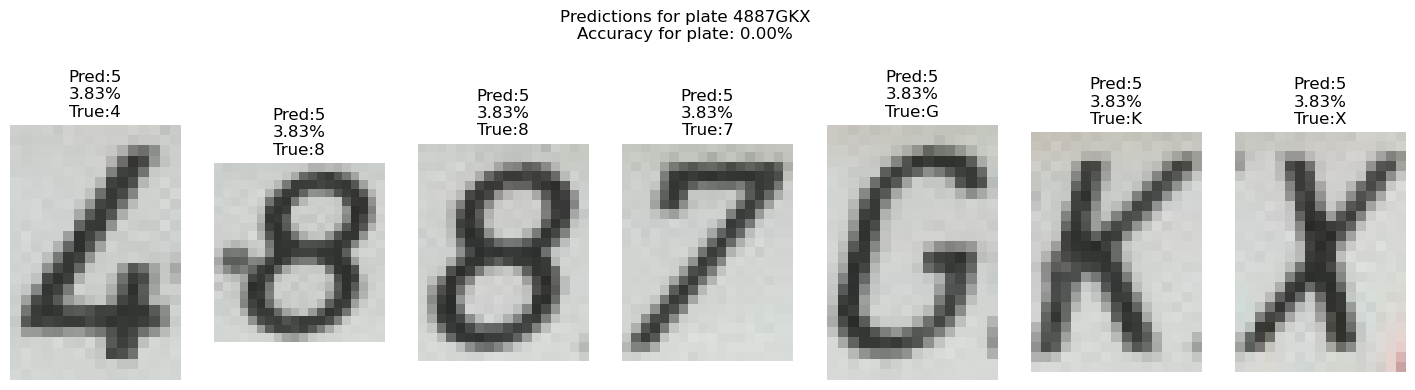

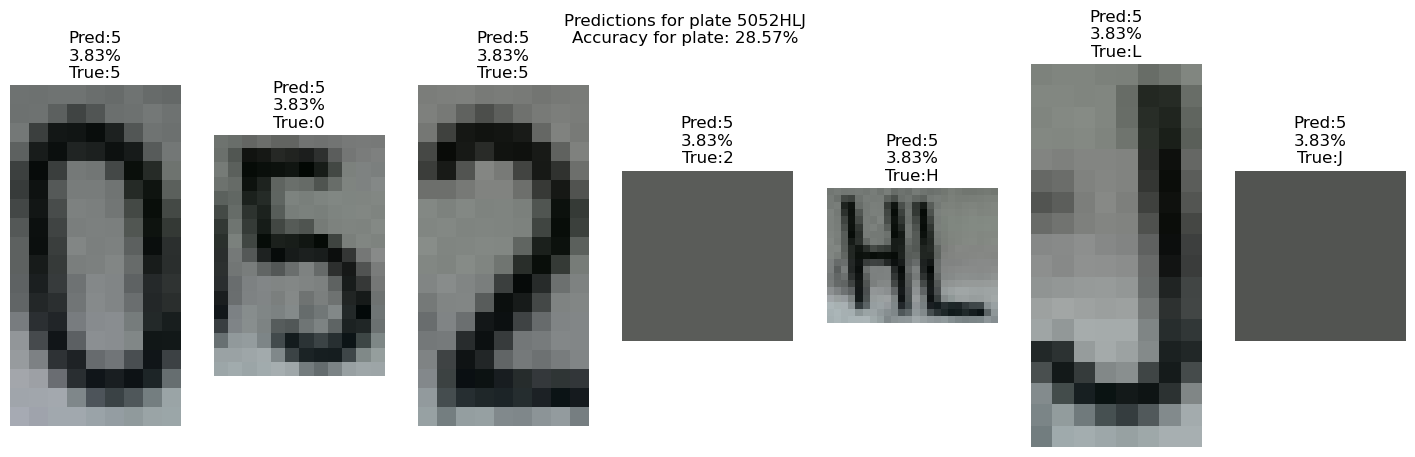

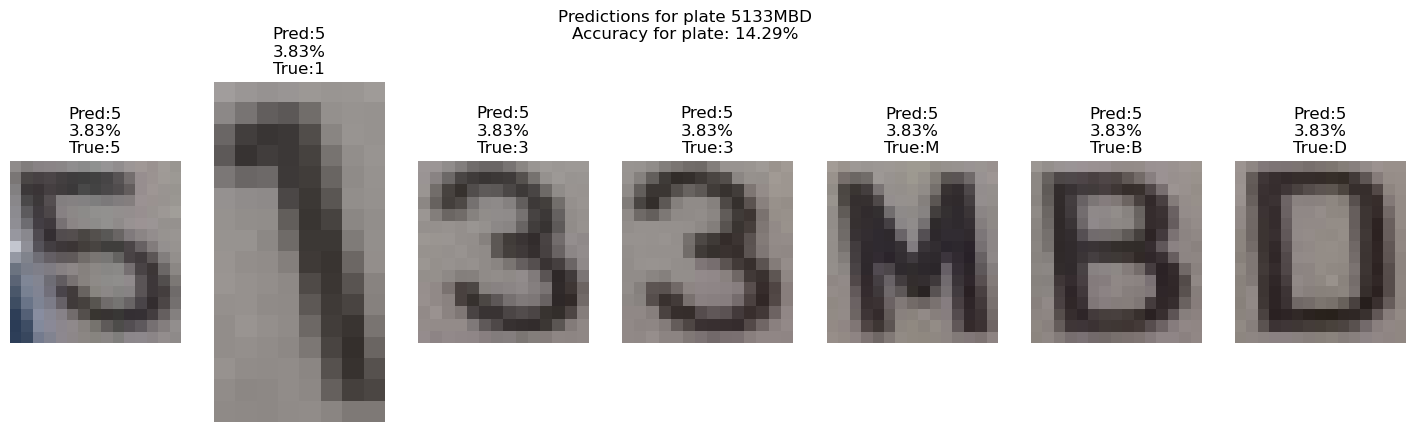

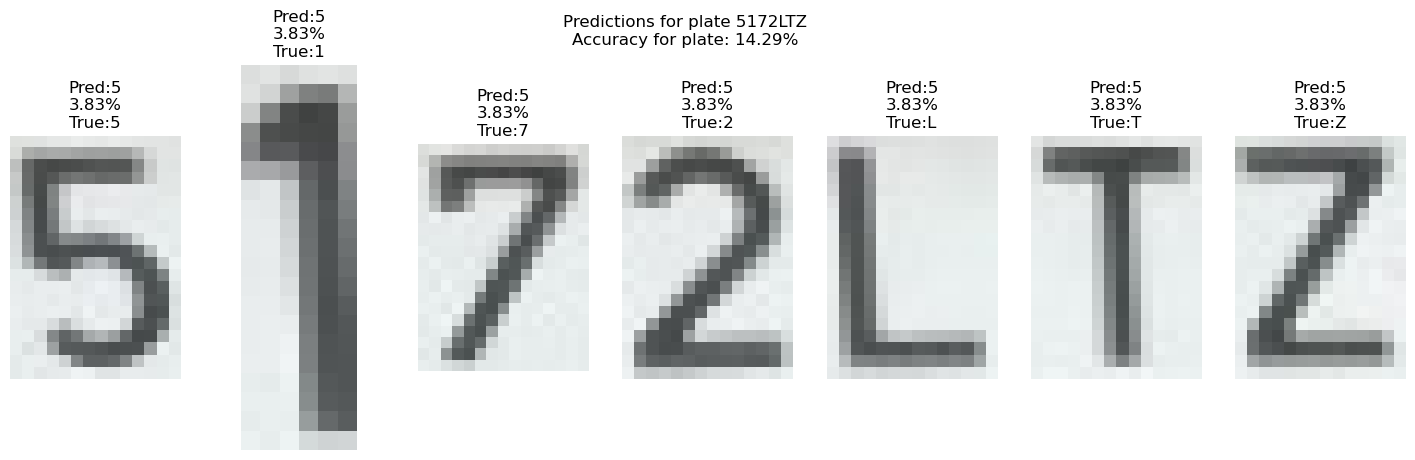

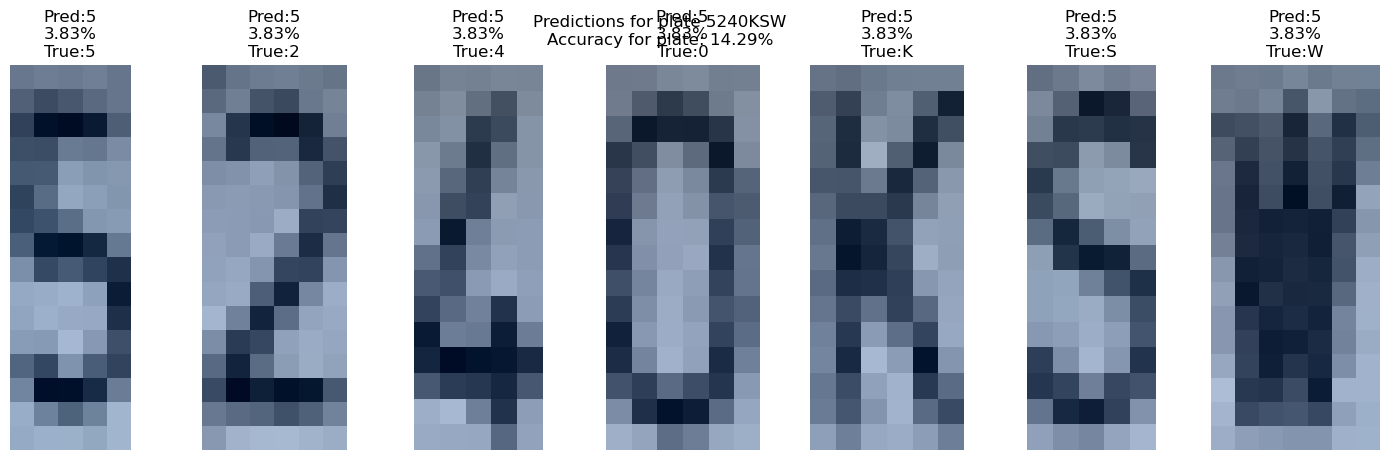

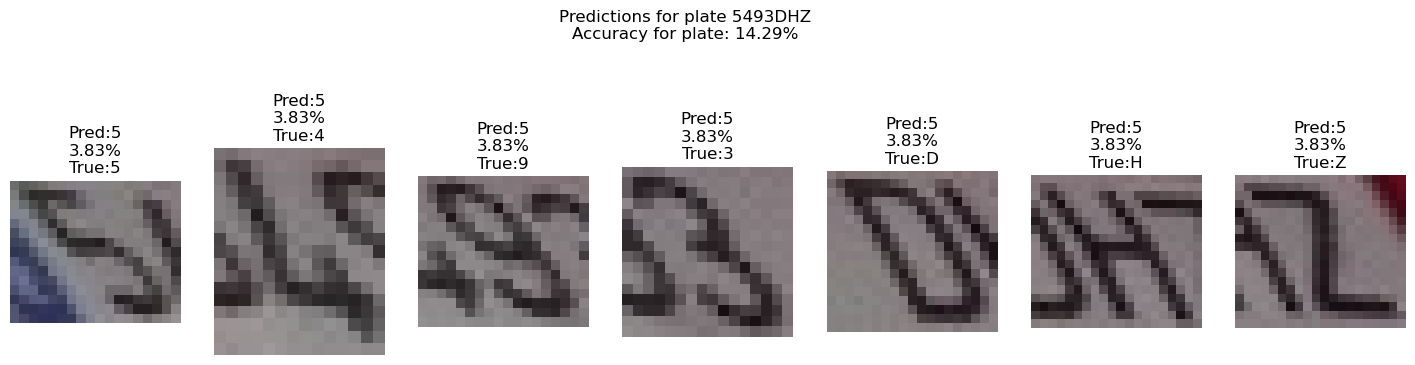

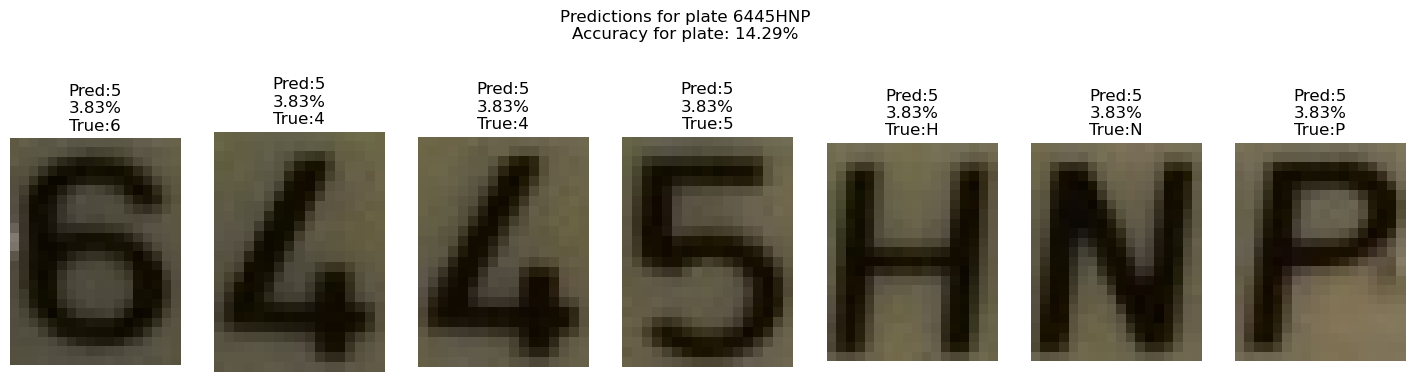

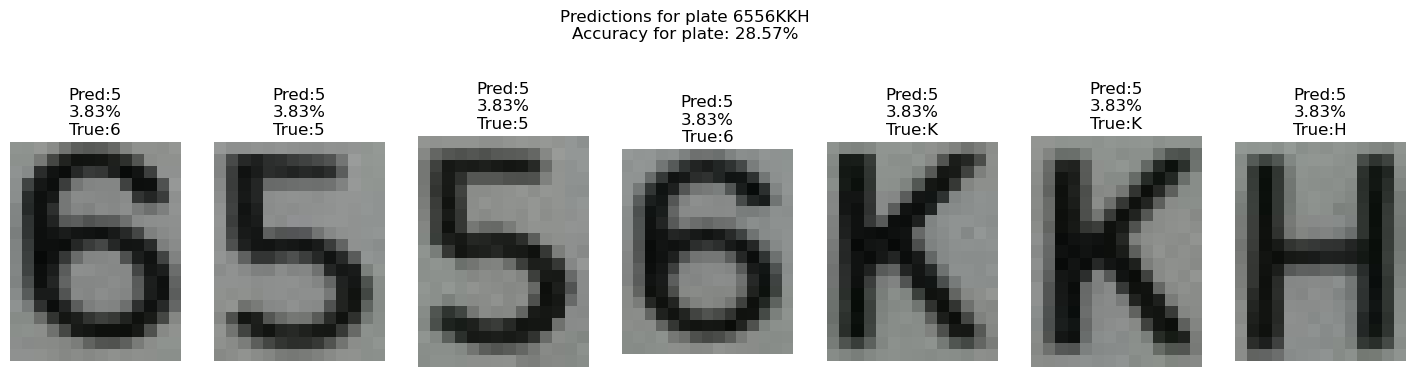

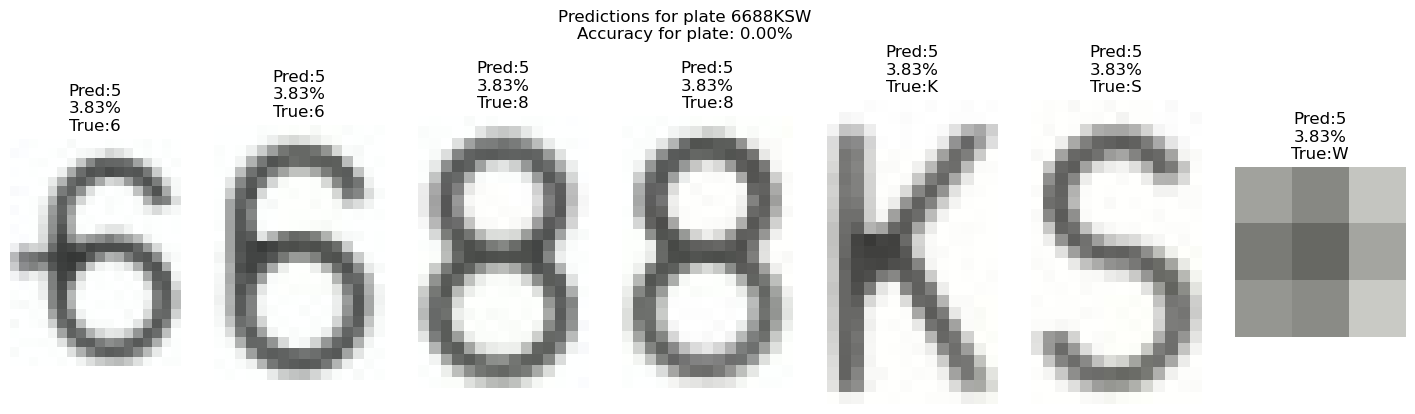

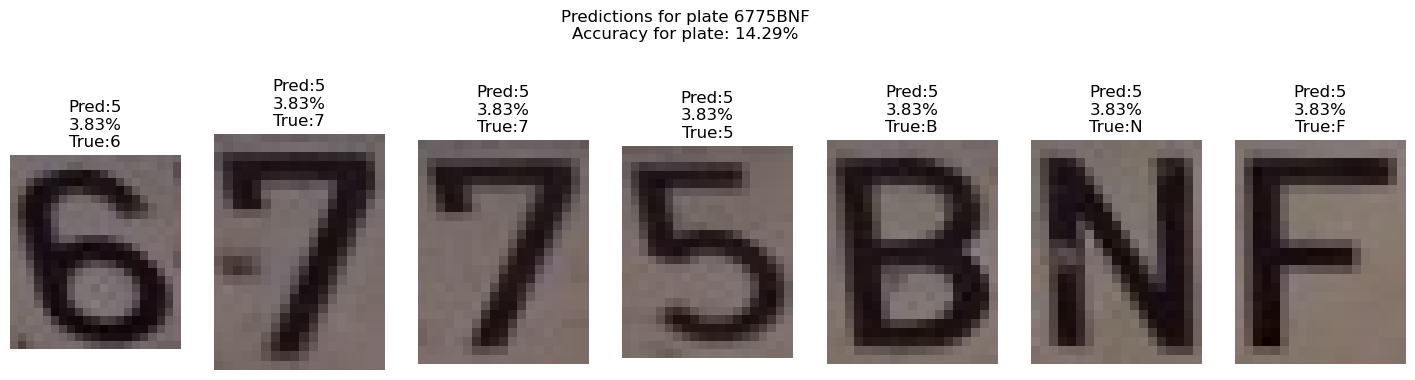

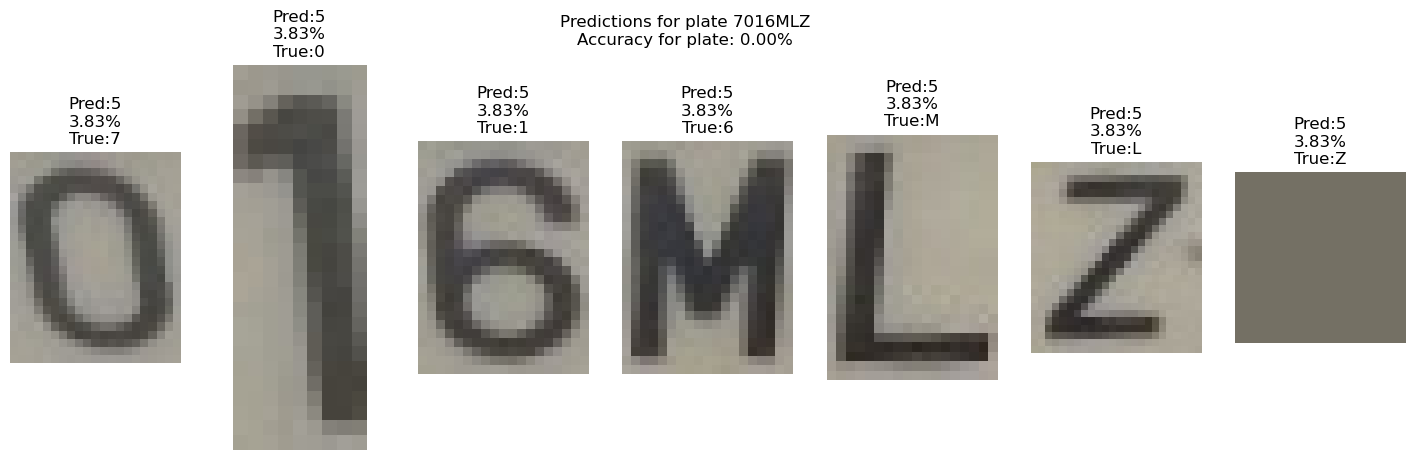

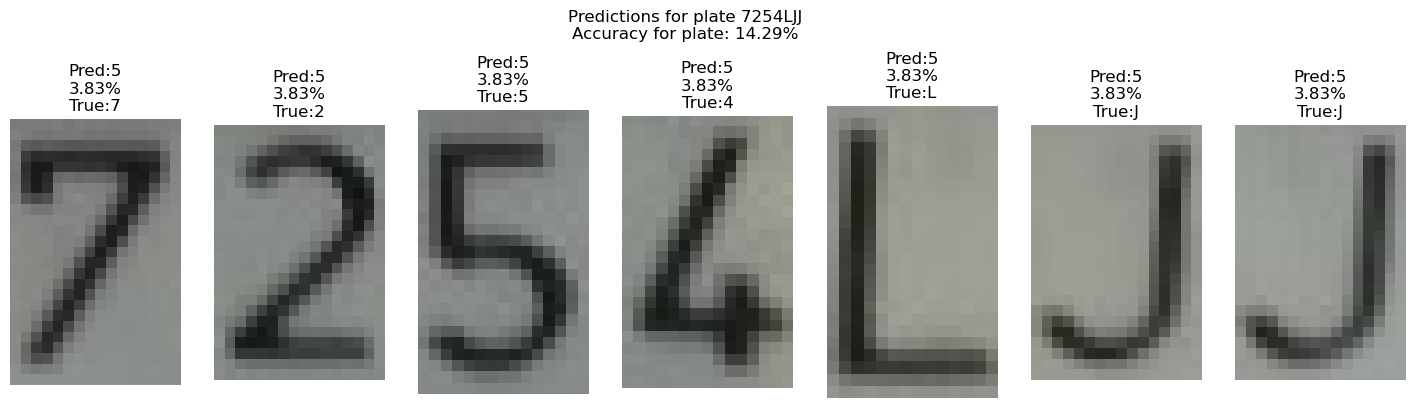

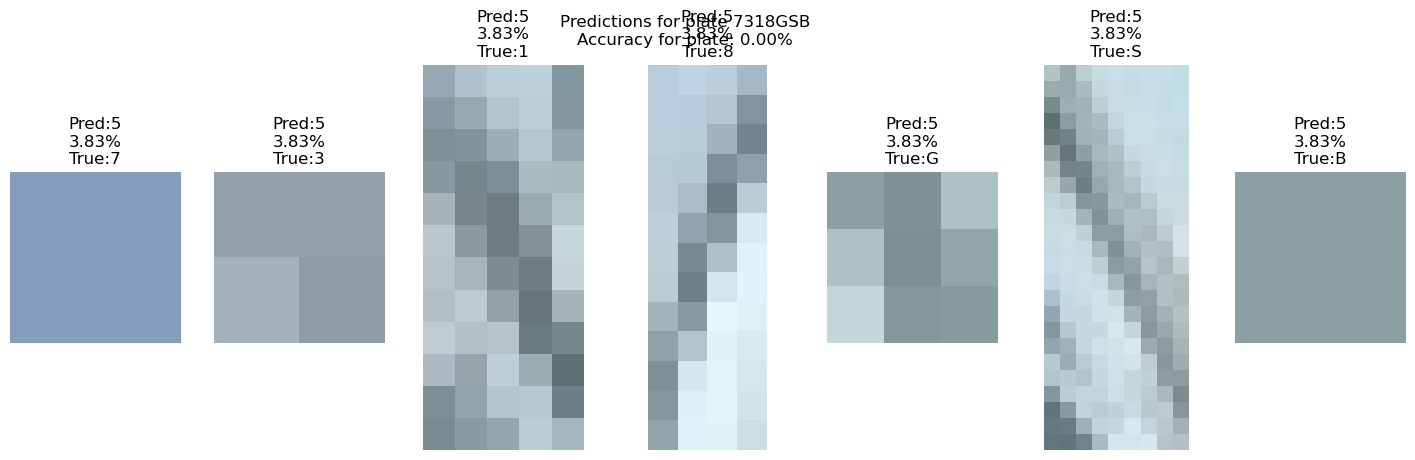

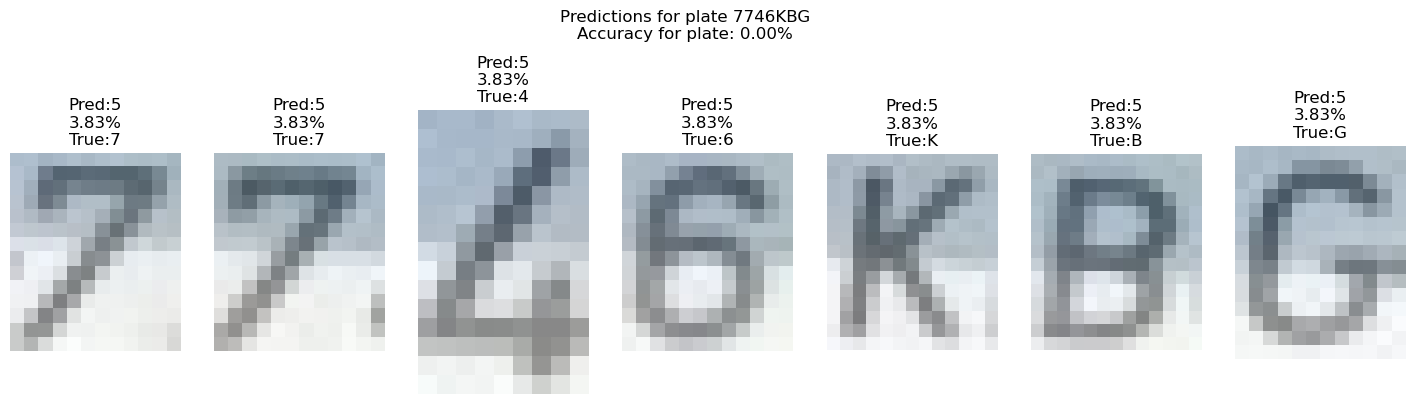

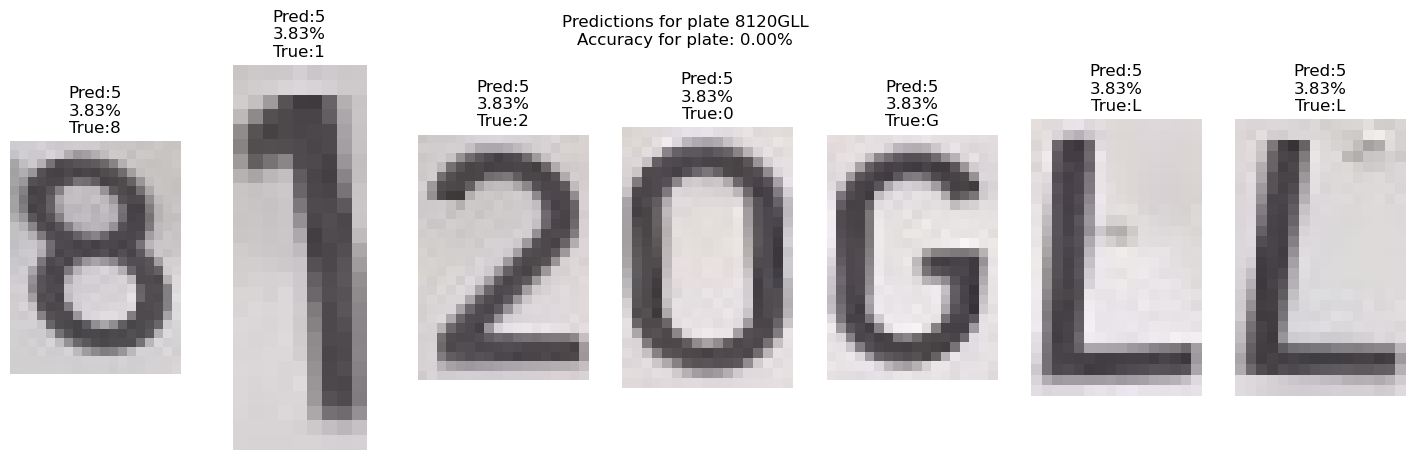

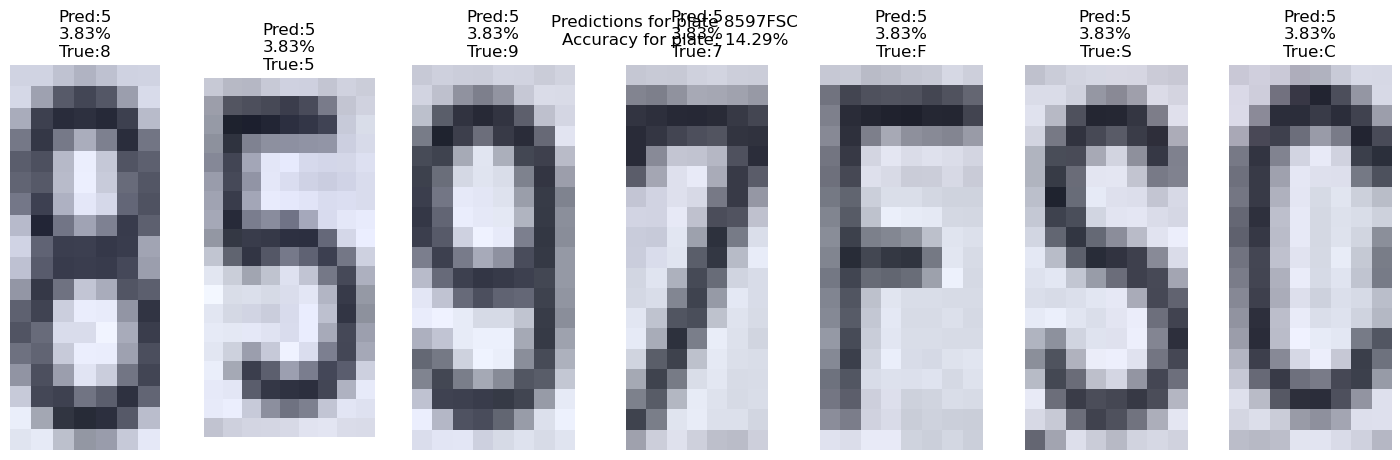

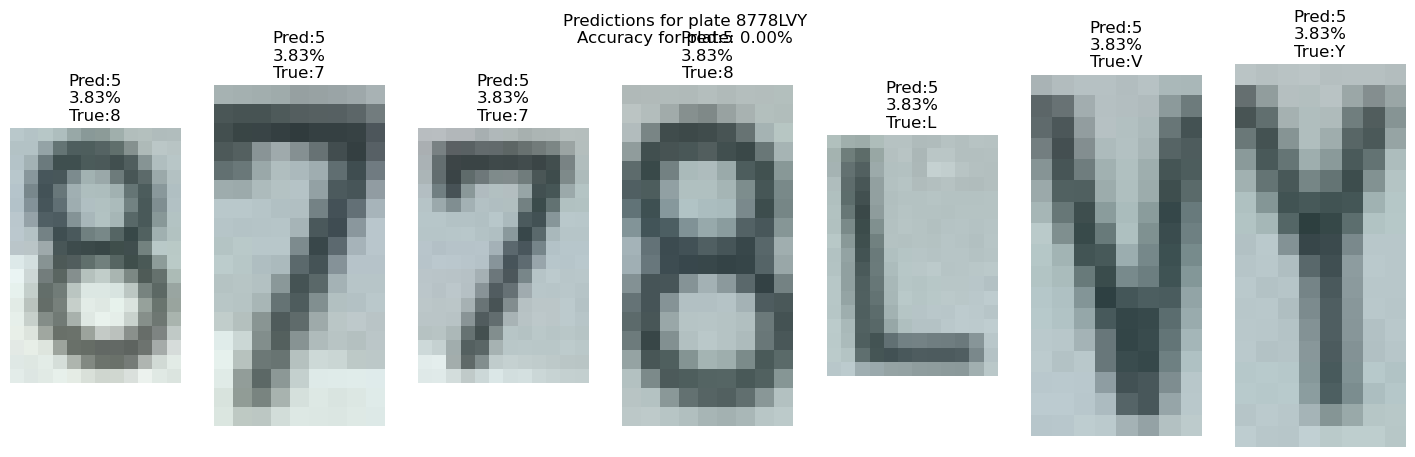

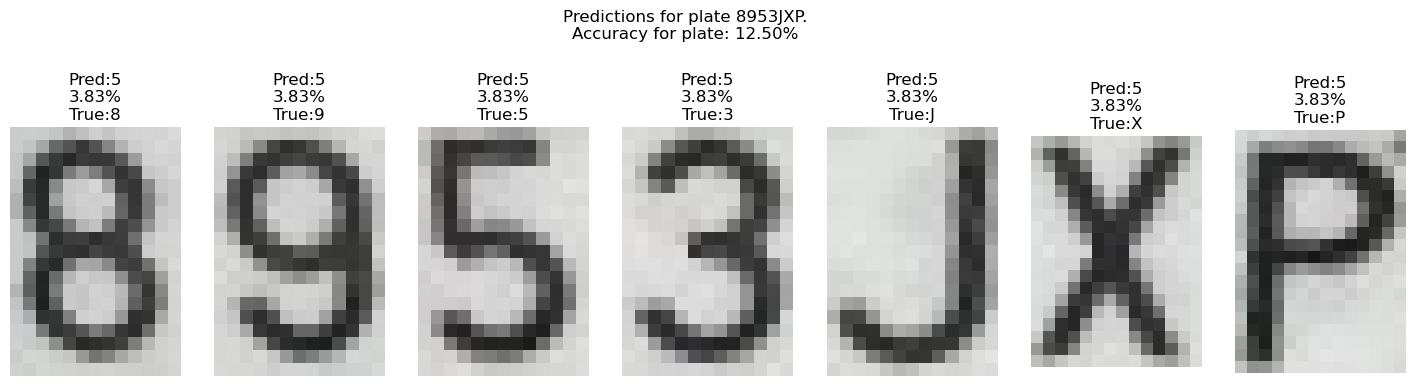

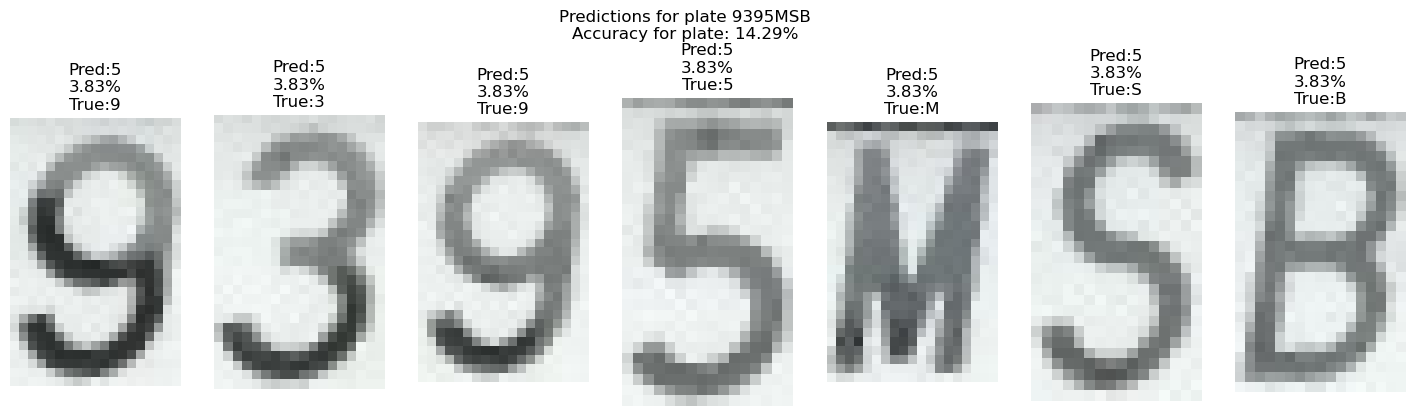

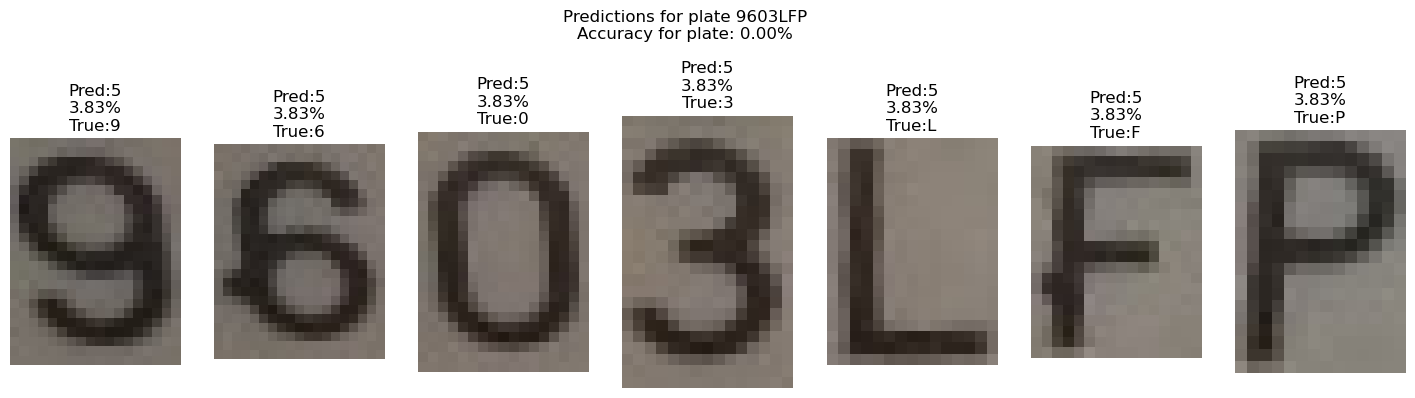

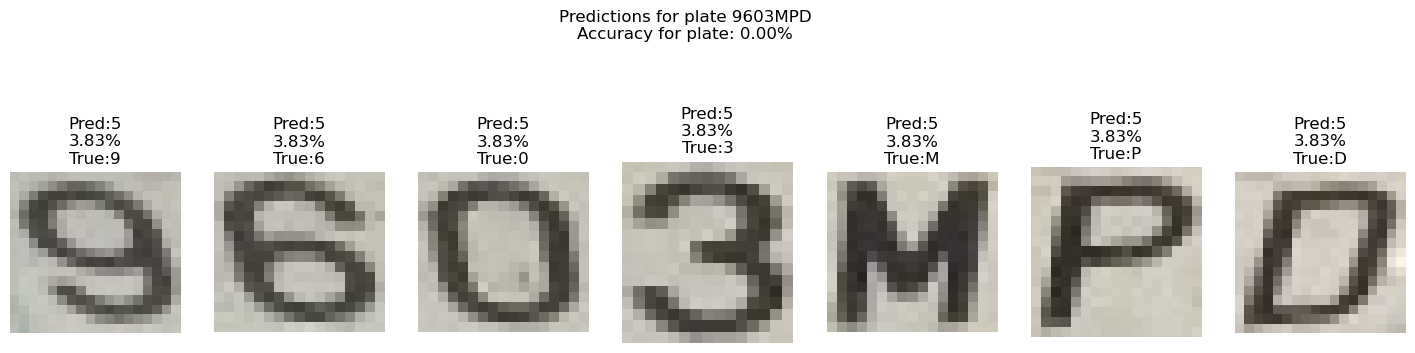

In [103]:
images_path = 'PlateDigits/Extra/'
correct_digits, correct_plates, total_digits, total_plates = predict(model, images_path)

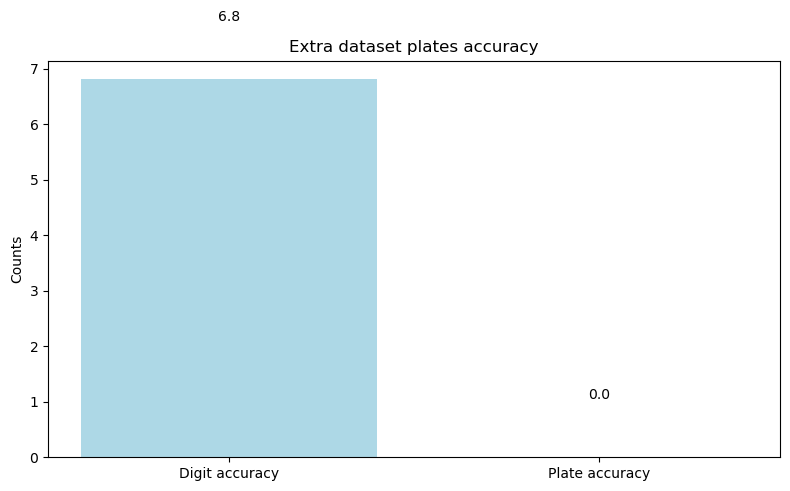

In [104]:
# Bar plot
digit_accuracy_x = (correct_digits / total_digits) *100
plate_accuracy_x = (correct_plates / total_plates) *100
bar_plot(values=[digit_accuracy_x, plate_accuracy_x], 
         categories=["Digit accuracy","Plate accuracy"], 
         type="Extra dataset", 
         colors=["lightblue","lightgreen"])

## 8. Results

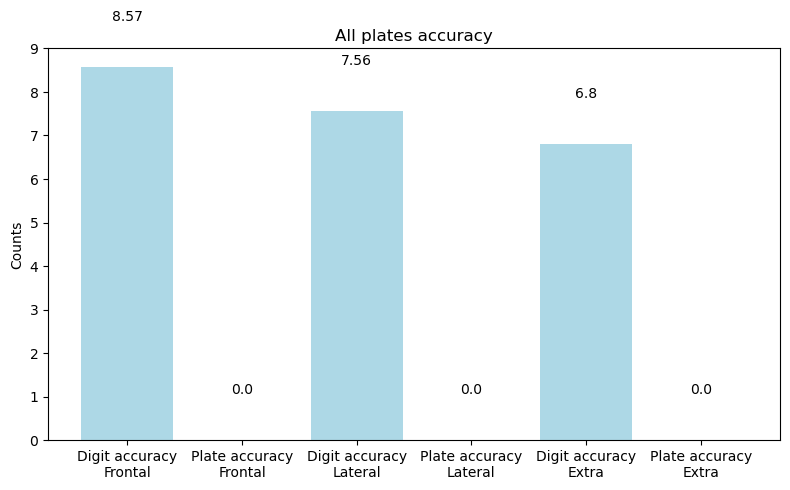

In [105]:
categories = ["Digit accuracy\nFrontal", "Plate accuracy\nFrontal",
              "Digit accuracy\nLateral", "Plate accuracy\nLateral",
              "Digit accuracy\nExtra", "Plate accuracy\nExtra"]
values = [digit_accuracy_frontal, plate_accuracy_frontal,
          digit_accuracy_lateral, plate_accuracy_lateral,
          digit_accuracy_x, plate_accuracy_x]
colors = ['lightblue','lightgreen','lightblue','lightgreen','lightblue','lightgreen']

bar_plot(values, categories, type="All", colors=colors)

## 9. Hyperparameters

- 20 epochs

*Model 1*:
- optimizer: SGD
- criterion: CrossEntropyLoss
- lr=0.001
- momentum=0.9
- Results
    * Average training epoch loss =
    * Validation accuracy = 
    * Validation loss =
    * Test accuracy = 
    * Test loss = 
    * Digit accuracy Frontal = 78.1%
    * Plate accuracy Frontal = 33.33%
    * Digit accuracy Lateral = 74.79%
    * Plate accuracy Lateral = 17.65%
    * Digit accuracy Extra = 60.2%
    * Plate accuracy Extra = 4.76%

*Model 2*:
- optimizer: Adam
- criterion: CrossEntropyLoss
- lr=0.001
- Results
    * Average training epoch loss = 0.0010
    * Validation accuracy = 99.67%
    * Validation loss = 0.0146
    * Test accuracy = 99.37%
    * Test loss = 0.0631
    * Digit accuracy Frontal = 82.86%
    * Plate accuracy Frontal = 46.67%
    * Digit accuracy Lateral = 78.15%
    * Plate accuracy Lateral = 29.41%
    * Digit accuracy Extra = 61.22%
    * Plate accuracy Extra = 7.14%

*Model 3*:
- optimizer: Adam
- criterion: CrossEntropyLoss
- lr=0.01
- Results
    * Average training epoch loss = 0.5336
    * Validation accuracy = 10.81%
    * Validation loss = 3.3872
    * Test accuracy = 11.74%
    * Test loss = 3.3843
    * Digit accuracy Frontal = 8.57%
    * Plate accuracy Frontal = 0%
    * Digit accuracy Lateral = 7.56%
    * Plate accuracy Lateral = 0%
    * Digit accuracy Extra = 6.8%
    * Plate accuracy Extra = 0%
